# **Angular Reconstruction & Cosmic Ray Classification**  
### **Luis F. Navarro** – luis.navarrof@usm.cl  
#### **2025**

#### This notebook addresses the classification of cosmic rays (photons vs protons), the estimation of their energy levels, and the accurate reconstruction of their arrival angle using simulated data from CORSIKA under the CONDOR observatory conditions. The workflow includes: data loading and preprocessing, class, energy, and angle balancing, exploratory visualization, normalization and sequence assembly, and the construction of deep learning models (1D CNN + MultiHeadAttention) for classification and regression tasks. Oversampling/undersampling techniques are used to ensure a balanced dataset by particle type, energy level, and angle, and a stratified train/val/test split is performed. Finally, detailed metrics and visualizations of performance for all three tasks are presented, along with error analysis and prediction dispersion. Each section contains explanatory comments about the steps and their relevance.

#### Import libraries

In [32]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import optuna
from collections import Counter
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import keras_tuner as kt
from tensorflow.keras import Input
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks, backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cb_early = callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
cb_rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [2]:
print("Python version:", os.sys.version)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("TensorFlow:", tf.__version__)
print("Seaborn:", sns.__version__)
print("Keras Tuner:", kt.__version__)

Python version: 3.9.20 | packaged by conda-forge | (main, Sep 30 2024, 17:43:23) [MSC v.1929 64 bit (AMD64)]
NumPy: 1.26.4
Pandas: 2.2.3
TensorFlow: 2.10.0
Seaborn: 0.13.2
Keras Tuner: 1.4.7


### _Optional: Configure Tensorflow to reduce memory waste_

In [3]:
# Para evitar errores de memoria en GPU
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
tf.keras.mixed_precision.set_global_policy('mixed_float16')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6


### Define incident energy and the types of cosmic rays to predict (Photon and Proton)

In [4]:
# Parámetros generales
energies    = ['5E2', '8E2']
particles   = ["Photon", "Proton"]
base_dir    = r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR_ChPT_Datasets"
predicts_dir = r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR Angular Reconstruction\Results"
if not os.path.exists(predicts_dir):
    os.makedirs(predicts_dir)

plt.style.use('seaborn-v0_8-whitegrid')

### Some useful functions to define:

- **F1-metric.** To use it later in classification training.
- **Rotate-shower.** Auxiliary function to augment data by rotating particle showers _(currently not used)_.
- **Compute-Radial-Profile.** Auxiliary function to calculate the number of particles impacting in concentric rings around the shower _(currently not used)_.
- **Build-sequence.** Essential function that constructs each sequence corresponding to each particle shower.

In [5]:
# F1 score metric
def f1_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

In [6]:
# -------------------------------
# 1) FUNCIONES AUXILIARES
# -------------------------------

def rotate_shower(df, phi):
    """
    Rota los puntos (x_bin, y_bin) alrededor del origen por ángulo phi [rad].
    Devuelve un DataFrame rotado con las mismas columnas, solo modifica x_bin,y_bin.
    """
    r = np.sqrt(df['x_bin']**2 + df['y_bin']**2)
    theta = np.arctan2(df['y_bin'], df['x_bin'])
    theta_rot = theta + phi
    x_new = r * np.cos(theta_rot)
    y_new = r * np.sin(theta_rot)
    df_r = df.copy()
    df_r['x_bin'] = x_new
    df_r['y_bin'] = y_new
    return df_r

def compute_radial_profile(df, bin_edges):
    """
    Dado un DataFrame de ducha (x_bin,y_bin,particle_count), 
    calcula la suma de particle_count en anillos definidos por bin_edges.
    Retorna un vector de longitud len(bin_edges)-1.
    """
    x = df['x_bin'].values
    y = df['y_bin'].values
    cnt = df['particle_count'].values
    r = np.sqrt(x**2 + y**2)
    sums, _ = np.histogram(r, bins=bin_edges, weights=cnt)
    return sums.astype(np.float32)

def build_sequence(df):
    """
    Dado un DataFrame df con columnas normalizadas [x_bin,y_bin,t_bin], 
    construye la secuencia (x_bin, y_bin, t_bin)
    """
    xs = df['x_bin'].values
    ys = df['y_bin'].values
    ts = df['t_bin'].values
    seq = np.stack([
        xs.astype(np.float32),
        ys.astype(np.float32),
        ts.astype(np.float32)
    ], axis=1)
        
    # Ordenar por tiempo
    idx_sort = np.argsort(seq[:, 2])
    return seq[idx_sort]


### Data reading and processing.
#### Creation of lists to store the loaded data.

- **Aug_seqs.** Contains the sequences of particle showers and their variables (x_bin, y_bin, and t_bin).
- **Aug_angles.** Labels corresponding to the incidence angle of each sequence.
- **Aug_labels.** Correspond to the particle type labels (0: Proton, 1: Photon).
- **tp_list.** List that stores the total number of particles generated by each sequence.
- **mt_list.** Stores the maximum durations of each sequence.

In [7]:
# -------------------------------
# RECOLECCIÓN, LECTURA Y PROCESAMIENTO DE DATOS EN UN SOLO PASO
# -------------------------------

file_paths = []
energy_labels = []
aug_seqs  = []
aug_angles= []
aug_labels= []
aug_energies = []
tp_list   = []
mt_list   = []

all_x = []
all_y = []
all_t = []

for energy in energies:
    for part in particles:
        label = 0 if part == "Proton" else 1
        folder = os.path.join(base_dir, f"CONDOR_{energy}_{part}_ChPt", "binned_data")
        if not os.path.isdir(folder):
            continue
        for run_f in os.listdir(folder):
            run_p = os.path.join(folder, run_f)
            if not (os.path.isdir(run_p) and run_f.startswith("run_")):
                continue
            for csv_f in os.listdir(run_p):
                if not csv_f.endswith(".csv"):
                    continue
                path = os.path.join(run_p, csv_f)
                if os.stat(path).st_size == 0:
                    continue
                try:
                    angle = float(csv_f.split("_")[7])
                except:
                    continue
                if angle > 50.0:
                    continue

                # Leer y procesar el archivo solo una vez
                df0 = pd.read_csv(path)
                total_p = len(df0)
                if total_p < 5: # Filtrar mínimo de partículas
                    continue

                max_t = df0['t_bin'].max()
                seq = df0[['x_bin', 'y_bin', 't_bin']].values.astype(np.float32)
                idx_sort = np.argsort(seq[:, 2])
                seq = seq[idx_sort]

                # Guardar para procesamiento posterio
                file_paths.append((path, angle, label))
                energy_labels.append(energy)
                aug_seqs.append(seq)
                aug_angles.append(angle)
                aug_labels.append(label)
                aug_energies.append(energy)
                tp_list.append(total_p)
                mt_list.append(max_t)

                # Para los scalers
                all_x.append(df0['x_bin'].values)
                all_y.append(df0['y_bin'].values)
                all_t.append(df0['t_bin'].values)

# Ajustar scalers después de recolectar todos los datos
all_x = np.concatenate(all_x).reshape(-1, 1)
all_y = np.concatenate(all_y).reshape(-1, 1)
all_t = np.concatenate(all_t).reshape(-1, 1)

scaler_x = StandardScaler()
scaler_y = StandardScaler()
scaler_t = MinMaxScaler()

scaler_x.fit(all_x)
scaler_y.fit(all_y)
scaler_t.fit(all_t)

MinMaxScaler()

In [8]:
# Extra features (total_particles y max_time)
tp_arr = np.array(tp_list, dtype=np.float32)
mt_arr = np.array(mt_list, dtype=np.float32)

X_extra_full = np.stack([tp_arr, mt_arr], axis=1).astype(np.float32)

### Visualization of the data distribution by angle and particle type.

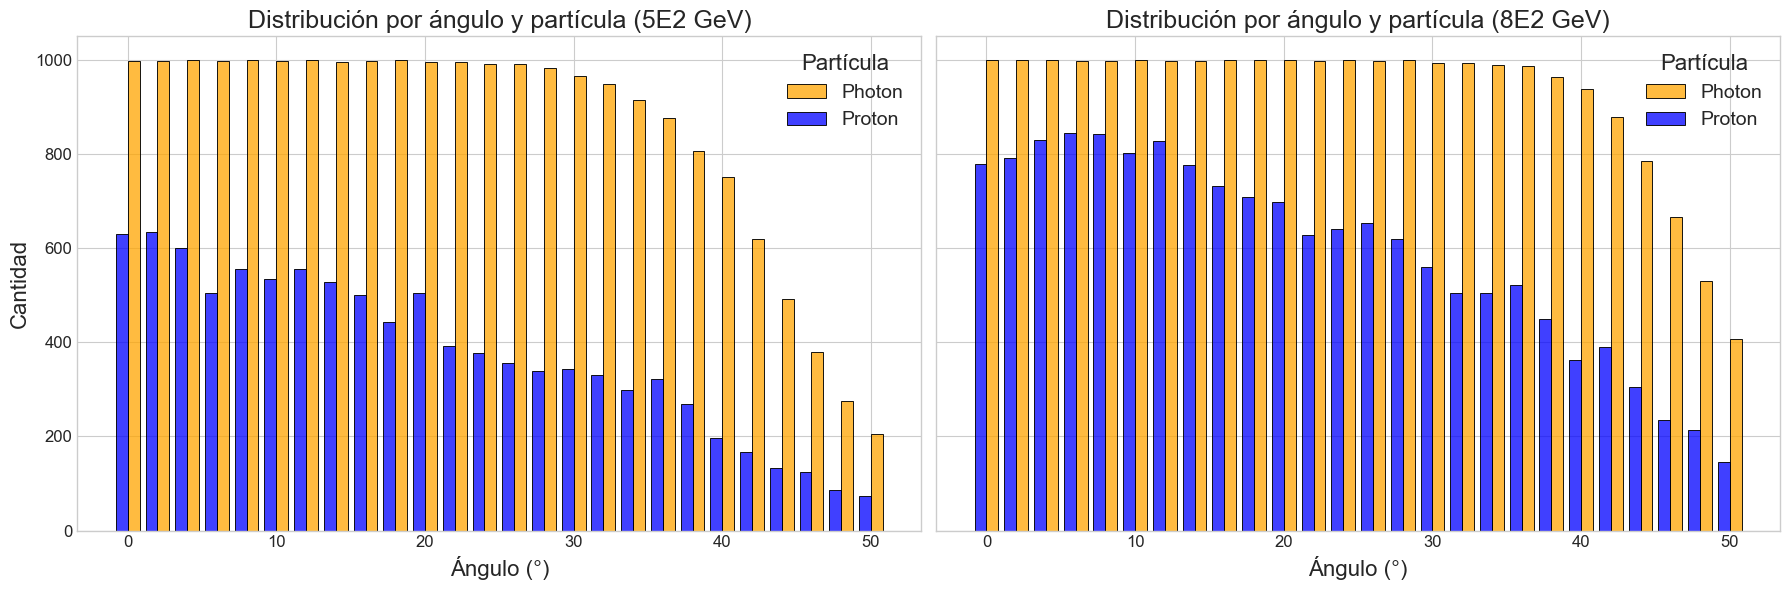

In [9]:
# Visualización de la distribución de ángulo y partícula para todas las energías presentes en los datos
df_dist = pd.DataFrame({
    'angle': aug_angles,
    'label': aug_labels,
    'energy': aug_energies
})
df_dist['particle'] = df_dist['label'].map({0: 'Proton', 1: 'Photon'})

unique_energies = sorted(df_dist['energy'].unique())
n_energies = len(unique_energies)
fig, axes = plt.subplots(1, n_energies, figsize=(9 * n_energies, 6), sharey=True)

if n_energies == 1:
    axes = [axes]

for i, energy_val in enumerate(unique_energies):
    ax = axes[i]
    df_e = df_dist[df_dist['energy'] == energy_val]
    sns.histplot(
        data=df_e,
        x='angle',
        hue='particle',
        bins=np.arange(-1, 52, 2),
        multiple='dodge',
        shrink=0.8,
        palette={'Photon': 'orange', 'Proton': 'blue'},
        hue_order=['Proton', 'Photon'],
        ax=ax
    )
    ax.set_xlabel("Ángulo (°)", fontsize=16)
    ax.set_ylabel("Cantidad", fontsize=16)
    ax.set_title(f"Distribución por ángulo y partícula ({energy_val} GeV)", fontsize=18)
    ax.legend(title="Partícula", labels=["Photon", "Proton"], fontsize=14, title_fontsize=16)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "angle_label_distribution_by_energy.png"))
plt.show()

### Sequence balancing (1000 sequences per angle for both particles).

In [68]:
target = 1000  # Mantén este valor

# Estratificación adicional por energía y ángulo
df_full = pd.DataFrame({
    'angle': aug_angles,
    'label': aug_labels,      
    'energy': aug_energies
})

# Agregar índices para poder referenciar las muestras originales
df_full['idx'] = df_full.index

# MEJORAR: Agregar bins de ángulo para balanceo más fino
def create_angle_bins(angles, n_bins=10):
    """Crea bins de ángulo para balanceo más fino"""
    return pd.cut(angles, bins=n_bins, labels=False)

df_full['angle_bin'] = create_angle_bins(df_full['angle'])

# Balancear por (angle_bin, label, energy) en lugar de (angle, label, energy)
chosen = []
for energy_val in sorted(df_full['energy'].unique()):
    for angle_bin in sorted(df_full['angle_bin'].unique()):
        for lbl in [0, 1]:
            # Filtrar datos por las condiciones
            mask = (
                (df_full['energy'] == energy_val) & 
                (df_full['angle_bin'] == angle_bin) & 
                (df_full['label'] == lbl)
            )
            idxs = df_full[mask]['idx'].values
                         
            n = len(idxs)
            if n == 0:
                continue
                             
            # Target ajustado por dificultad del bin
            # Más muestras para bins de ángulos altos (más difíciles)
            angle_weight = 1.0 + (angle_bin / 10.0) * 0.5  # 1.0 a 1.5
            adjusted_target = int(target * angle_weight)
                         
            if n >= adjusted_target:
                pick = np.random.choice(idxs, size=adjusted_target, replace=False)
            else:
                extra = adjusted_target - n
                pick = np.concatenate([idxs, np.random.choice(idxs, size=extra, replace=True)])
            
            chosen.extend(pick.tolist())

In [69]:
# Generar subconjunto balanceado
chosen = np.array(chosen, dtype=int)
aug_seqs = np.array(aug_seqs, dtype=object)
aug_angles = np.array(aug_angles)
aug_labels = np.array(aug_labels)
aug_energies = np.array(aug_energies)

X_seq_bal = aug_seqs[chosen]
X_ext_bal = X_extra_full[chosen]
y_ang_bal = aug_angles[chosen]
y_lbl_bal = aug_labels[chosen]
y_energy_bal = aug_energies[chosen]

df_bal = pd.DataFrame({'angle': y_ang_bal, 'label': y_lbl_bal, 'energy': y_energy_bal})


ANÁLISIS DE DISTRIBUCIÓN POST-BALANCEO

📊 ESTADÍSTICAS GENERALES:
Total de muestras seleccionadas: 49000
Muestras únicas: 42100
Porcentaje de duplicación: 14.1%

🏷️  DISTRIBUCIÓN POR ETIQUETAS:
Label 0: 24500 muestras (50.0%)
Label 1: 24500 muestras (50.0%)

⚡ DISTRIBUCIÓN POR ENERGÍA:
Energía 5E2: 24500 muestras (50.0%)
Energía 8E2: 24500 muestras (50.0%)

📐 DISTRIBUCIÓN POR BINS DE ÁNGULO:
Bin 0: 4000 muestras (8.2%)
Bin 1: 4200 muestras (8.6%)
Bin 2: 4400 muestras (9.0%)
Bin 3: 4600 muestras (9.4%)
Bin 4: 4800 muestras (9.8%)
Bin 5: 5000 muestras (10.2%)
Bin 6: 5200 muestras (10.6%)
Bin 7: 5400 muestras (11.0%)
Bin 8: 5600 muestras (11.4%)
Bin 9: 5800 muestras (11.8%)


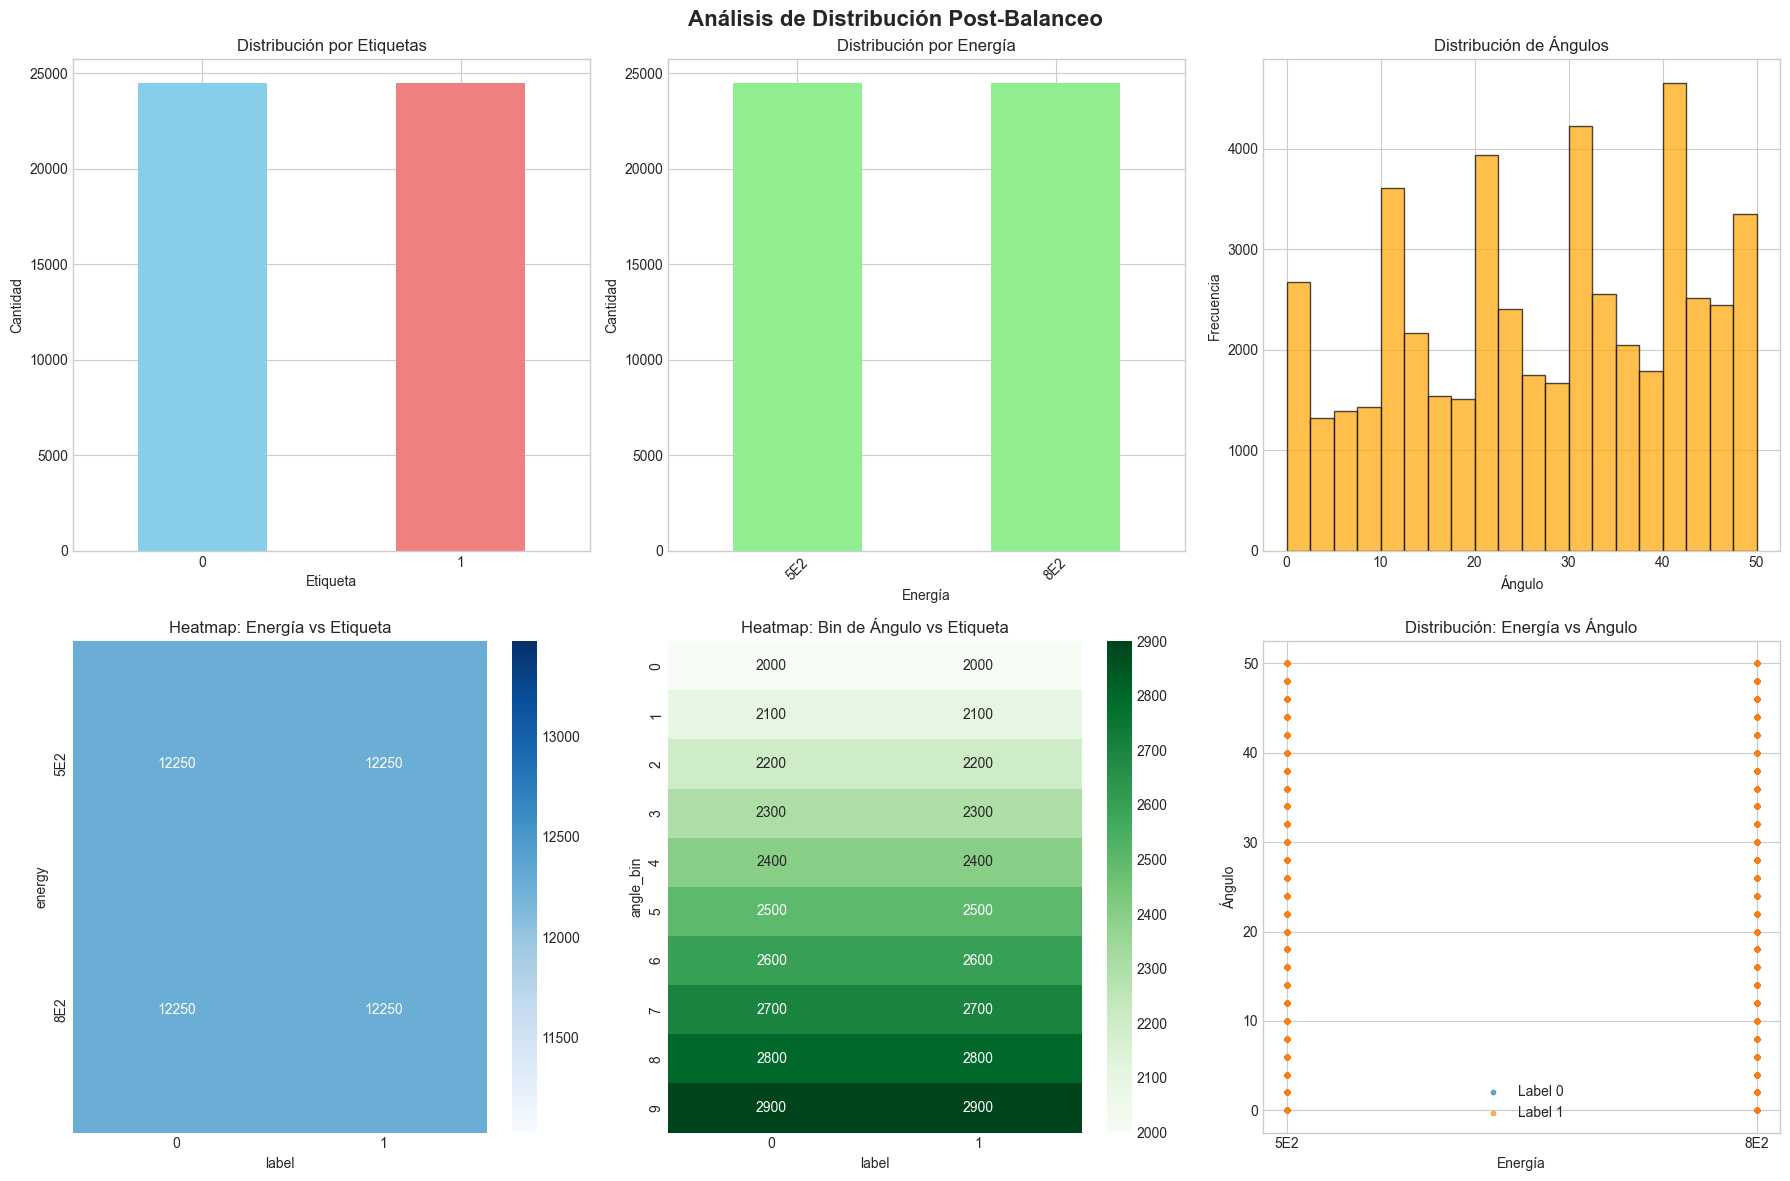


📋 TABLA DETALLADA (Energía x Bin_Ángulo x Etiqueta):
label                  0       1
energy angle_bin                
5E2    0          1000.0  1000.0
       1          1050.0  1050.0
       2          1100.0  1100.0
       3          1150.0  1150.0
       4          1200.0  1200.0
       5          1250.0  1250.0
       6          1300.0  1300.0
       7          1350.0  1350.0
       8          1400.0  1400.0
       9          1450.0  1450.0
8E2    0          1000.0  1000.0
       1          1050.0  1050.0
       2          1100.0  1100.0
       3          1150.0  1150.0
       4          1200.0  1200.0
       5          1250.0  1250.0
       6          1300.0  1300.0
       7          1350.0  1350.0
       8          1400.0  1400.0
       9          1450.0  1450.0

⚖️  VERIFICACIÓN DE BALANCE:
Mínimo de muestras en cualquier grupo: 1000
Máximo de muestras en cualquier grupo: 1450
Ratio de balance (max/min): 1.45
✅ Balance BUENO (ratio <= 2.0)


In [70]:
def analyze_balanced_distribution(chosen_indices, aug_angles, aug_labels, aug_energies):
    """
    Analiza y visualiza la distribución de datos después del balanceo
    
    Parameters:
    chosen_indices: lista de índices seleccionados después del balanceo
    aug_angles, aug_labels, aug_energies: arrays originales de datos
    """
    
    # Crear DataFrame con datos seleccionados
    selected_data = pd.DataFrame({
        'angle': aug_angles[chosen_indices],
        'label': aug_labels[chosen_indices],
        'energy': aug_energies[chosen_indices]
    })
    
    # Crear bins de ángulo para análisis
    selected_data['angle_bin'] = pd.cut(selected_data['angle'], bins=10, labels=False)
    
    print("="*60)
    print("ANÁLISIS DE DISTRIBUCIÓN POST-BALANCEO")
    print("="*60)
    
    # 1. Estadísticas básicas
    print(f"\n📊 ESTADÍSTICAS GENERALES:")
    print(f"Total de muestras seleccionadas: {len(chosen_indices)}")
    print(f"Muestras únicas: {len(set(chosen_indices))}")
    print(f"Porcentaje de duplicación: {(1 - len(set(chosen_indices))/len(chosen_indices))*100:.1f}%")
    
    # 2. Distribución por labels
    print(f"\n🏷️  DISTRIBUCIÓN POR ETIQUETAS:")
    label_counts = selected_data['label'].value_counts().sort_index()
    for label, count in label_counts.items():
        percentage = (count / len(selected_data)) * 100
        print(f"Label {label}: {count} muestras ({percentage:.1f}%)")
    
    # 3. Distribución por energía
    print(f"\n⚡ DISTRIBUCIÓN POR ENERGÍA:")
    energy_counts = selected_data['energy'].value_counts().sort_index()
    for energy, count in energy_counts.items():
        percentage = (count / len(selected_data)) * 100
        print(f"Energía {energy}: {count} muestras ({percentage:.1f}%)")
    
    # 4. Distribución por bins de ángulo
    print(f"\n📐 DISTRIBUCIÓN POR BINS DE ÁNGULO:")
    angle_bin_counts = selected_data['angle_bin'].value_counts().sort_index()
    for bin_idx, count in angle_bin_counts.items():
        percentage = (count / len(selected_data)) * 100
        print(f"Bin {bin_idx}: {count} muestras ({percentage:.1f}%)")
    
    # 5. Crear visualizaciones
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Análisis de Distribución Post-Balanceo', fontsize=16, fontweight='bold')
    
    # Gráfico 1: Distribución de etiquetas
    ax1 = axes[0, 0]
    label_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral'])
    ax1.set_title('Distribución por Etiquetas')
    ax1.set_xlabel('Etiqueta')
    ax1.set_ylabel('Cantidad')
    ax1.tick_params(axis='x', rotation=0)
    
    # Gráfico 2: Distribución de energías
    ax2 = axes[0, 1]
    energy_counts.plot(kind='bar', ax=ax2, color='lightgreen')
    ax2.set_title('Distribución por Energía')
    ax2.set_xlabel('Energía')
    ax2.set_ylabel('Cantidad')
    ax2.tick_params(axis='x', rotation=45)
    
    # Gráfico 3: Distribución de ángulos (histograma)
    ax3 = axes[0, 2]
    ax3.hist(selected_data['angle'], bins=20, alpha=0.7, color='orange', edgecolor='black')
    ax3.set_title('Distribución de Ángulos')
    ax3.set_xlabel('Ángulo')
    ax3.set_ylabel('Frecuencia')
    
    # Gráfico 4: Heatmap - Energía vs Etiqueta
    ax4 = axes[1, 0]
    pivot_energy_label = selected_data.pivot_table(
        values='angle', index='energy', columns='label', aggfunc='count', fill_value=0
    )
    sns.heatmap(pivot_energy_label, annot=True, fmt='d', ax=ax4, cmap='Blues')
    ax4.set_title('Heatmap: Energía vs Etiqueta')
    
    # Gráfico 5: Heatmap - Bin de Ángulo vs Etiqueta
    ax5 = axes[1, 1]
    pivot_angle_label = selected_data.pivot_table(
        values='energy', index='angle_bin', columns='label', aggfunc='count', fill_value=0
    )
    sns.heatmap(pivot_angle_label, annot=True, fmt='d', ax=ax5, cmap='Greens')
    ax5.set_title('Heatmap: Bin de Ángulo vs Etiqueta')
    
    # Gráfico 6: Distribución 3D (Energía, Ángulo, Etiqueta)
    ax6 = axes[1, 2]
    for label in [0, 1]:
        subset = selected_data[selected_data['label'] == label]
        ax6.scatter(subset['energy'], subset['angle'], 
                   alpha=0.6, label=f'Label {label}', s=10)
    ax6.set_title('Distribución: Energía vs Ángulo')
    ax6.set_xlabel('Energía')
    ax6.set_ylabel('Ángulo')
    ax6.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 6. Tabla detallada por combinación
    print(f"\n📋 TABLA DETALLADA (Energía x Bin_Ángulo x Etiqueta):")
    detailed_table = selected_data.groupby(['energy', 'angle_bin', 'label']).size().reset_index(name='count')
    detailed_table = detailed_table.pivot_table(
        values='count', index=['energy', 'angle_bin'], columns='label', fill_value=0
    )
    print(detailed_table)
    
    # 7. Verificación de balance
    print(f"\n⚖️  VERIFICACIÓN DE BALANCE:")
    balance_check = selected_data.groupby(['energy', 'angle_bin', 'label']).size()
    min_samples = balance_check.min()
    max_samples = balance_check.max()
    balance_ratio = max_samples / min_samples if min_samples > 0 else float('inf')
    
    print(f"Mínimo de muestras en cualquier grupo: {min_samples}")
    print(f"Máximo de muestras en cualquier grupo: {max_samples}")
    print(f"Ratio de balance (max/min): {balance_ratio:.2f}")
    
    if balance_ratio <= 2.0:
        print("✅ Balance BUENO (ratio <= 2.0)")
    elif balance_ratio <= 5.0:
        print("⚠️  Balance MODERADO (ratio <= 5.0)")
    else:
        print("❌ Balance POBRE (ratio > 5.0)")
    
    return selected_data, detailed_table

selected_data, detailed_table = analyze_balanced_distribution(chosen, aug_angles, aug_labels, aug_energies)

### Visualization of the data removed and added after balancing

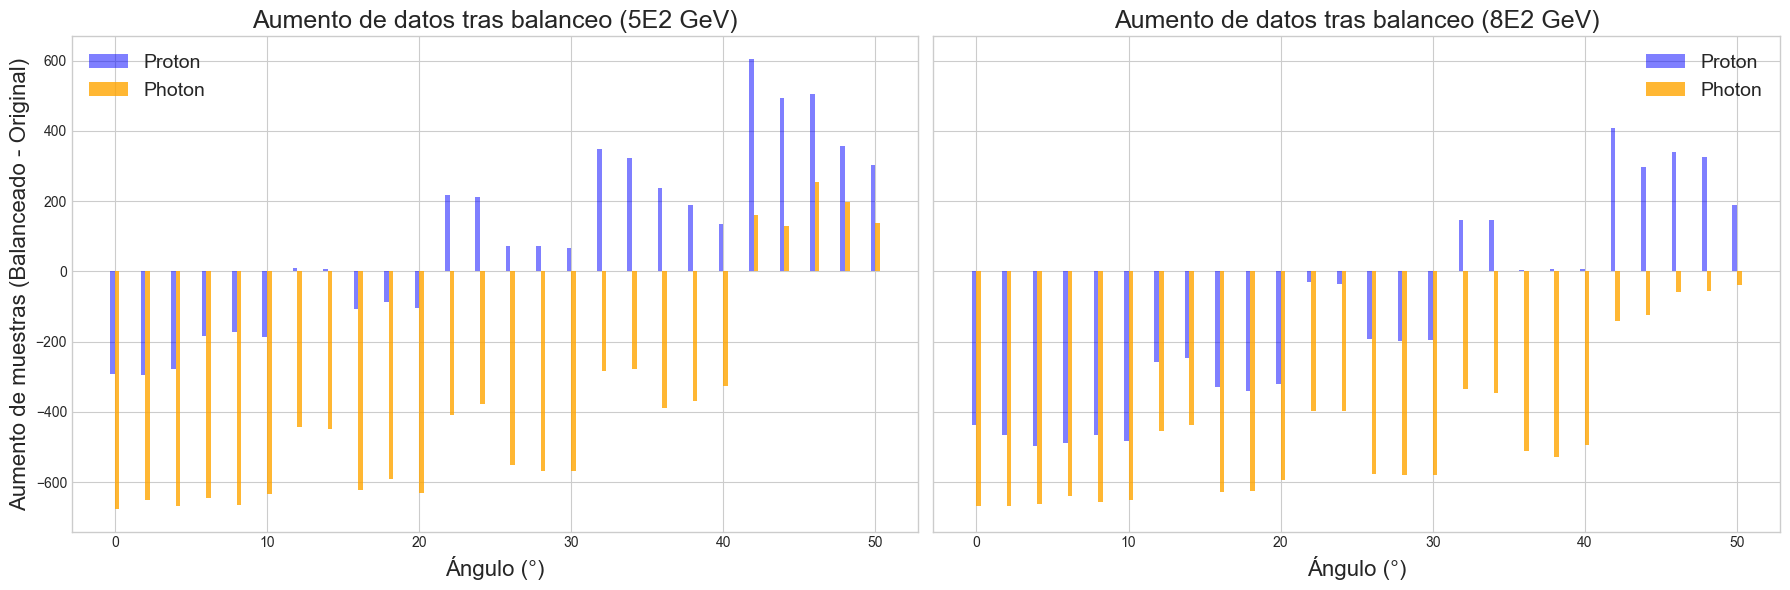

In [71]:
# Calcular la cantidad de datos originales y balanceados por ángulo y partícula, separado por energía (generalizado para cualquier cantidad de energías)
unique_energies = sorted(df_dist['energy'].unique())
n_energies = len(unique_energies)
fig, axes = plt.subplots(1, n_energies, figsize=(9 * n_energies, 6), sharey=True)

if n_energies == 1:
    axes = [axes]

for i, energy_val in enumerate(unique_energies):
    # Filtrar por energía
    orig_counts = df_dist[df_dist['energy'] == energy_val][['angle', 'label']].value_counts().sort_index()
    bal_counts = df_bal[df_bal['energy'] == energy_val][['angle', 'label']].value_counts().sort_index()

    angles = np.sort(np.unique(np.concatenate([orig_counts.index.get_level_values(0), bal_counts.index.get_level_values(0)])))
    labels = [0, 1]  # 0=Proton, 1=Photon

    diff_matrix = np.zeros((len(angles), 2), dtype=int)
    for j, ang in enumerate(angles):
        for lbl in labels:
            orig = orig_counts.get((ang, lbl), 0)
            bal = bal_counts.get((ang, lbl), 0)
            diff_matrix[j, lbl] = bal - orig

    ax = axes[i]
    ax.bar(angles - 0.15, diff_matrix[:, 0], width=0.3, color='blue', alpha=0.5, label='Proton', zorder=1)
    ax.bar(angles + 0.15, diff_matrix[:, 1], width=0.3, color='orange', alpha=0.8, label='Photon', zorder=2)
    ax.set_xlabel("Ángulo (°)", fontsize=16)
    if i == 0:
        ax.set_ylabel("Aumento de muestras (Balanceado - Original)", fontsize=16)
    ax.set_title(f"Aumento de datos tras balanceo ({energy_val} GeV)", fontsize=18)
    ax.legend(fontsize=14)
    ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "balance_diff_by_angle_particle_by_energy.png"))
plt.show()

### Box-plot visualization of the total number of particles generated for all sequences at each angle.

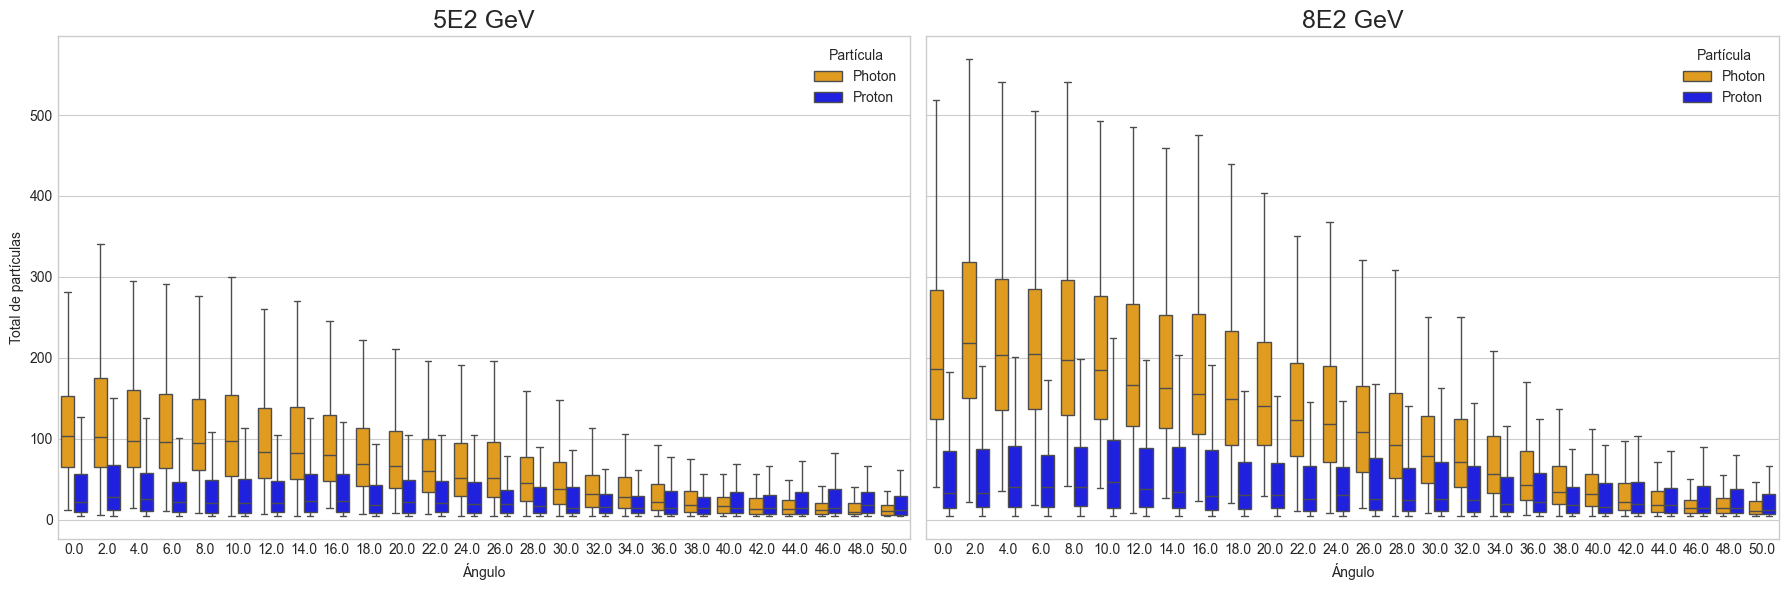

In [72]:
# Boxplot de total de partículas por ángulo y partícula, separado por energía (balanceado)

# Crear DataFrame balanceado con energía
df_bal_particles = pd.DataFrame({
    'total_particles': X_ext_bal[:, 0],
    'angle': y_ang_bal,
    'label': y_lbl_bal,
    'energy': y_energy_bal
})
df_bal_particles['particle'] = df_bal_particles['label'].map({0: 'Proton', 1: 'Photon'})

box_palette = {'Proton': 'blue', 'Photon': 'orange'}
box_kwargs = dict(
    x='angle',
    y='total_particles',
    hue='particle',
    palette=box_palette,
    showfliers=False,
    hue_order=['Photon', 'Proton']
)

unique_energies = sorted(df_bal_particles['energy'].unique())
n_energies = len(unique_energies)
fig, axes = plt.subplots(1, n_energies, figsize=(9 * n_energies, 6), sharey=True)

if n_energies == 1:
    axes = [axes]

for i, energy_val in enumerate(unique_energies):
    sns.boxplot(
        data=df_bal_particles[df_bal_particles['energy'] == energy_val],
        ax=axes[i],
        **box_kwargs
    )
    axes[i].set_xlabel("Ángulo")
    axes[i].set_ylabel("Total de partículas")
    axes[i].set_title(f"{energy_val} GeV", fontsize=18)
    axes[i].legend(title="Partícula")

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "boxplot_total_particles_by_angle_energy.png"))
plt.show()


### Box-plot visualization of the maximum duration of all sequences at each angle.

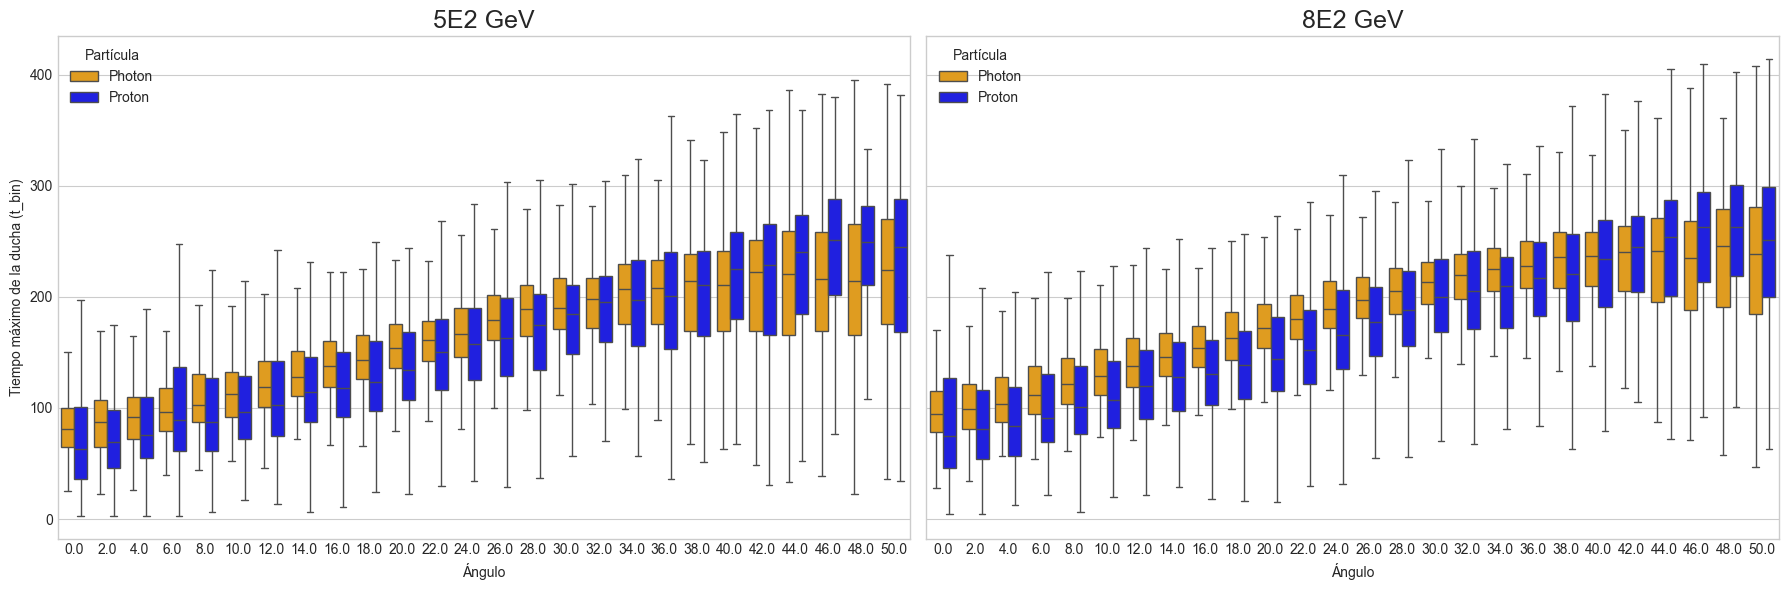

In [73]:
# Crear DataFrame para tiempos máximos por ángulo, partícula y energía (balanceado)
df_bal_time = pd.DataFrame({
    'max_time': X_ext_bal[:, 1],
    'angle': y_ang_bal,
    'label': y_lbl_bal,
    'energy': y_energy_bal
})
df_bal_time['particle'] = df_bal_time['label'].map({0: 'Proton', 1: 'Photon'})

# Visualización comparativa de la distribución de tiempos máximos (max_time) por ángulo y tipo de partícula
# para todas las energías presentes (balanceado)
unique_energies = sorted(df_bal_time['energy'].unique())
n_energies = len(unique_energies)
fig, axes = plt.subplots(1, n_energies, figsize=(9 * n_energies, 6), sharey=True)

if n_energies == 1:
    axes = [axes]

for i, energy_val in enumerate(unique_energies):
    sns.boxplot(
        data=df_bal_time[df_bal_time['energy'] == energy_val],
        x='angle',
        y='max_time',
        hue='particle',
        palette={'Proton': 'blue', 'Photon': 'orange'},
        hue_order=['Photon', 'Proton'],
        showfliers=False,
        ax=axes[i]
    )
    axes[i].set_xlabel("Ángulo")
    axes[i].set_ylabel("Tiempo máximo de la ducha (t_bin)")
    axes[i].set_title(f"{energy_val} GeV", fontsize=18)
    axes[i].legend(title="Partícula")

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "boxplot_max_time_by_angle_energy.png"))
plt.show()


### Data split into training, validation, and test sets

In [74]:
# Split train/val/test
train_idx, temp_idx = train_test_split(
    np.arange(len(X_seq_bal)),
    shuffle=True,
    stratify=list(zip(y_ang_bal, y_lbl_bal, y_energy_bal)),
    test_size=0.4,
    random_state=42
)
val_idx, test_idx = train_test_split(
    temp_idx,
    shuffle=True,
    stratify=list(zip(y_ang_bal[temp_idx], y_lbl_bal[temp_idx], y_energy_bal[temp_idx])),
    test_size=0.5,
    random_state=42
)

X_seq_train = X_seq_bal[train_idx]
y_ang_train = y_ang_bal[train_idx]
y_lbl_train = y_lbl_bal[train_idx]
y_energy_train = y_energy_bal[train_idx]

X_seq_val   = X_seq_bal[val_idx]
y_ang_val   = y_ang_bal[val_idx]
y_lbl_val   = y_lbl_bal[val_idx]
y_energy_val = y_energy_bal[val_idx]

X_seq_test  = X_seq_bal[test_idx]
y_ang_test  = y_ang_bal[test_idx]
y_lbl_test  = y_lbl_bal[test_idx]
y_energy_test = y_energy_bal[test_idx]


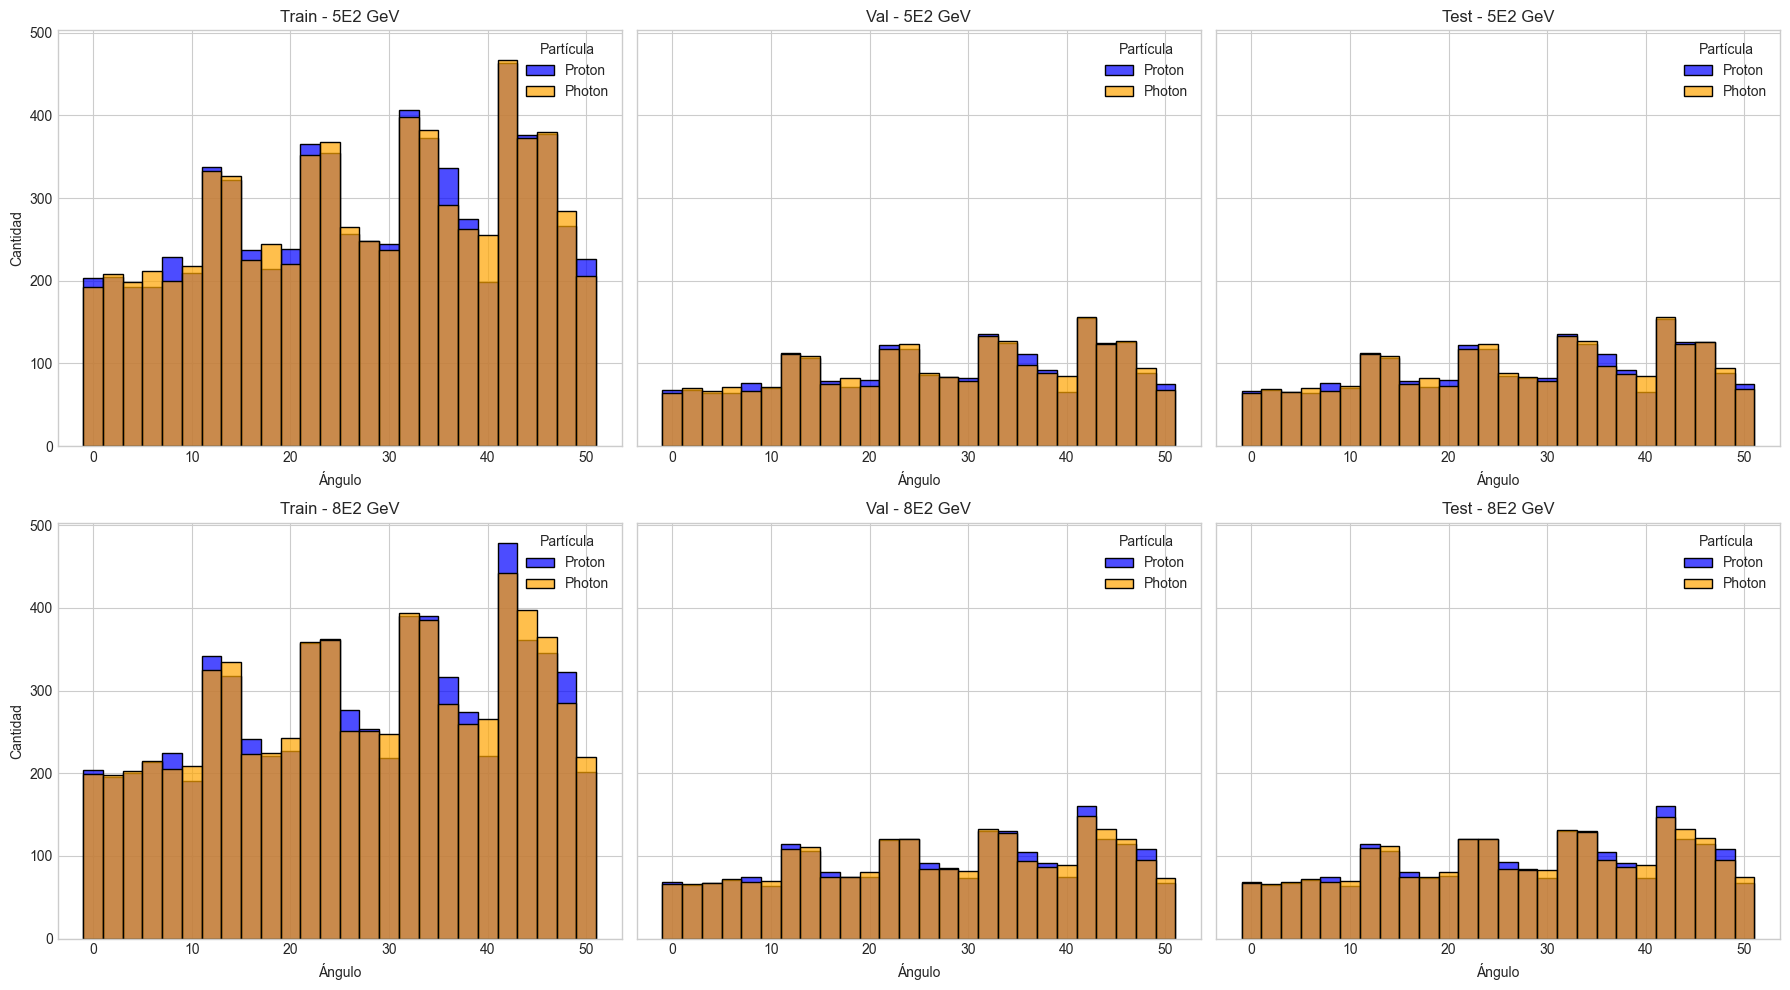

In [75]:
unique_energies = sorted(np.unique(np.concatenate([y_energy_train, y_energy_val, y_energy_test])))
fig, axes = plt.subplots(len(unique_energies), 3, figsize=(18, 5 * len(unique_energies)), sharey=True)

splits = [
    (y_ang_train, y_lbl_train, y_energy_train, "Train"),
    (y_ang_val, y_lbl_val, y_energy_val, "Val"),
    (y_ang_test, y_lbl_test, y_energy_test, "Test"),
]

for row, energy_val in enumerate(unique_energies):
    for col, (y_ang, y_lbl, y_energy, title) in enumerate(splits):
        ax = axes[row, col] if len(unique_energies) > 1 else axes[col]
        df_tmp = pd.DataFrame({'angle': y_ang, 'label': y_lbl, 'energy': y_energy})
        for lbl, part_name, color in zip([0, 1], ['Proton', 'Photon'], ['blue', 'orange']):
            sns.histplot(
                data=df_tmp[(df_tmp['energy'] == energy_val) & (df_tmp['label'] == lbl)],
                x='angle',
                bins=np.arange(-1, 52, 2),
                color=color,
                label=part_name,
                ax=ax,
                alpha=0.7
            )
        ax.set_title(f"{title} - {energy_val} GeV")
        ax.set_xlabel("Ángulo")
        ax.set_ylabel("Cantidad")
        ax.legend(title="Partícula")
plt.tight_layout()
plt.show()

### Sequence examples

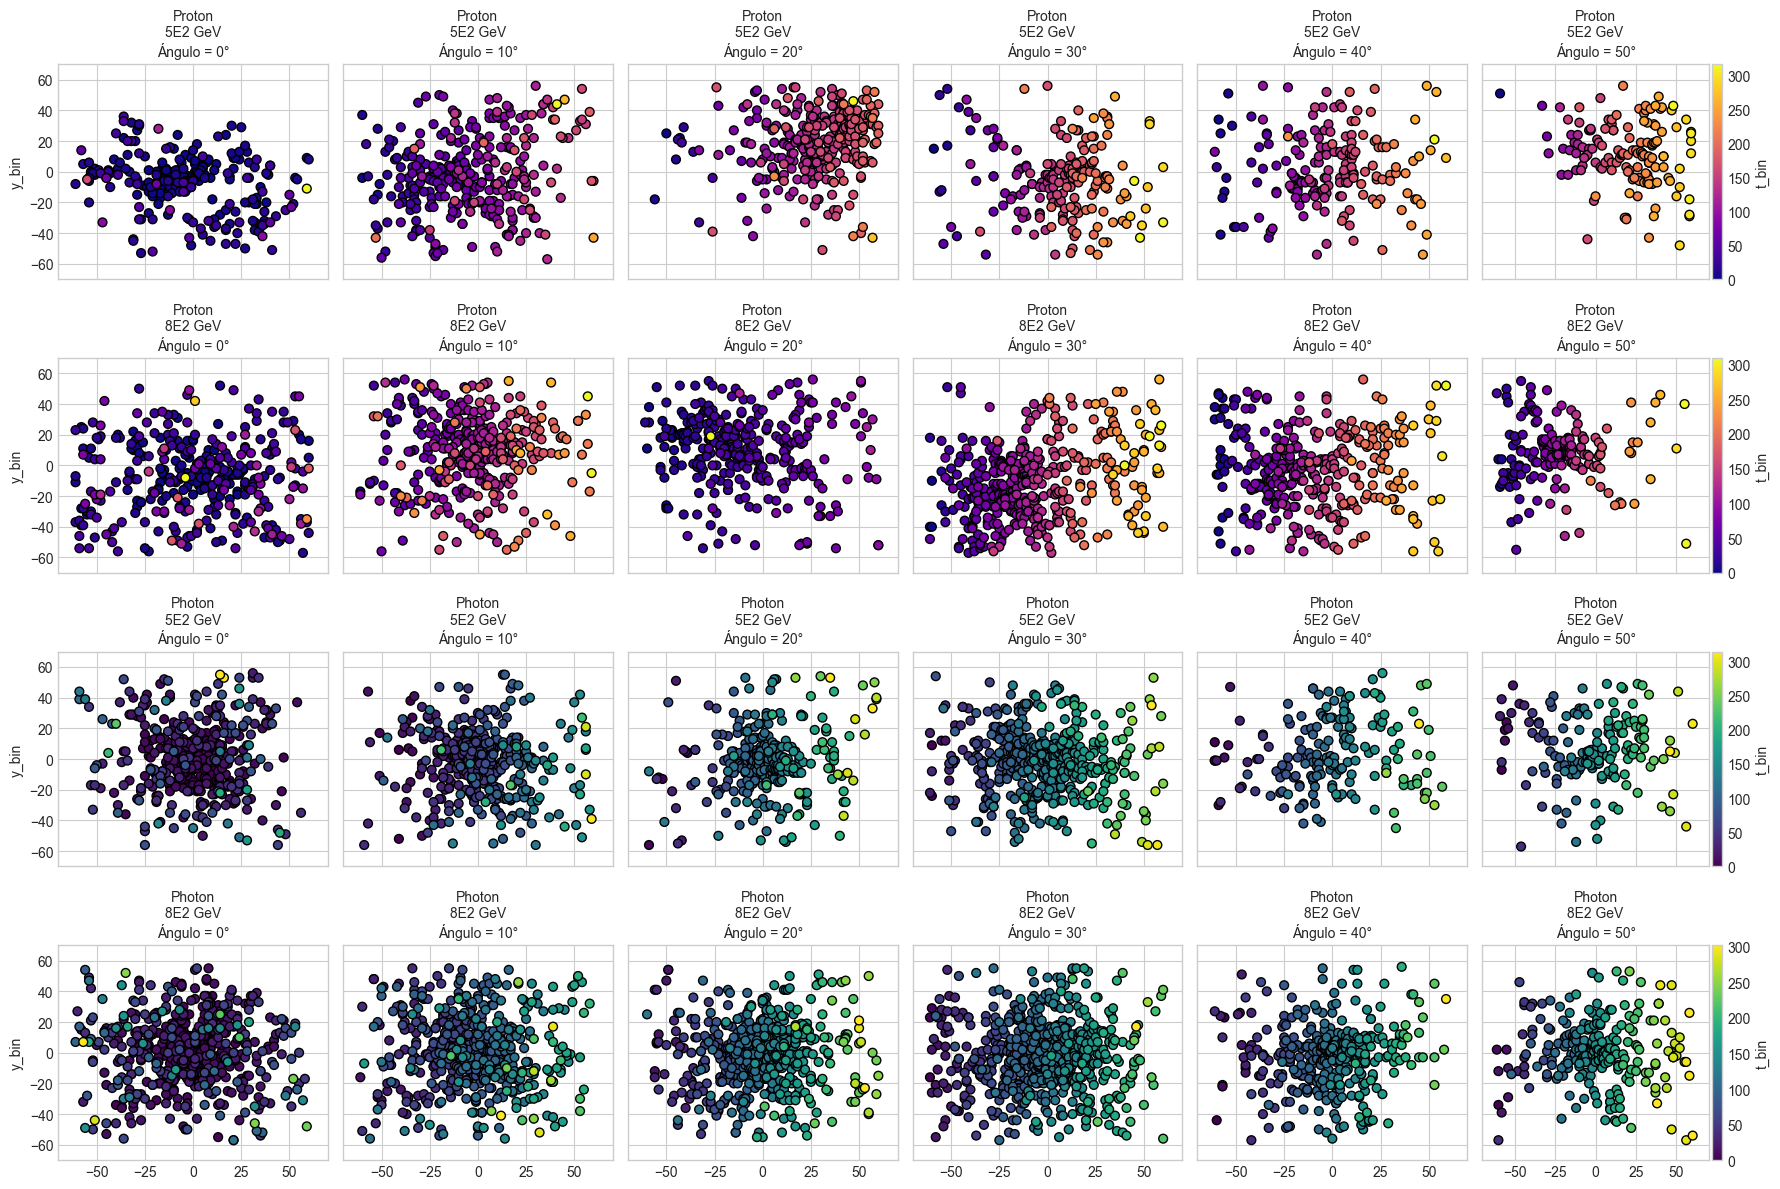

In [76]:
# Mostrar una secuencia de ejemplo con mayor número de partículas cada 10° desde 0 a 50 para ambas partículas y todas las energías en 2D (color = tiempo)

angles_to_show = np.arange(0, 51, 10)
unique_energies = sorted(df_bal['energy'].unique())
part_labels = ['Proton', 'Photon']

n_rows = len(unique_energies) * 2
n_cols = len(angles_to_show)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows), sharex=True, sharey=True)

for e_idx, energy_val in enumerate(unique_energies):
    for col, angle_val in enumerate(angles_to_show):
        ax = axes[e_idx, col]
        idxs = [k for k, (a, l, e) in enumerate(zip(y_ang_bal, y_lbl_bal, y_energy_bal)) if a == angle_val and l == 0 and e == energy_val]
        if idxs:
            idx_max = max(idxs, key=lambda k: len(X_seq_bal[k]))
            seq = X_seq_bal[idx_max]
            sc = ax.scatter(seq[:, 0], seq[:, 1], c=seq[:, 2], cmap='plasma', s=40, edgecolor='k')
            ax.set_title(f"Proton\n{energy_val} GeV\nÁngulo = {angle_val}°", fontsize=10)
            if col == 0:
                ax.set_ylabel("y_bin")
            if e_idx == n_rows - 1:
                ax.set_xlabel("x_bin")
            ax.set_xlim(-70, 70)
            ax.set_ylim(-70, 70)
            if col == n_cols - 1:
                cbar = plt.colorbar(sc, ax=ax, pad=0.01)
                cbar.set_label("t_bin")
        else:
            ax.set_title(f"Proton\n{energy_val} GeV\n{angle_val}°\nNo encontrado", fontsize=10)
            if col == 0:
                ax.set_ylabel("y_bin")
            if e_idx == n_rows - 1:
                ax.set_xlabel("x_bin")
                
for e_idx, energy_val in enumerate(unique_energies):
    for col, angle_val in enumerate(angles_to_show):
        ax = axes[e_idx + len(unique_energies), col]
        idxs = [k for k, (a, l, e) in enumerate(zip(y_ang_bal, y_lbl_bal, y_energy_bal)) if a == angle_val and l == 1 and e == energy_val]
        if idxs:
            idx_max = max(idxs, key=lambda k: len(X_seq_bal[k]))
            seq = X_seq_bal[idx_max]
            sc = ax.scatter(seq[:, 0], seq[:, 1], c=seq[:, 2], cmap='viridis', s=40, edgecolor='k')
            ax.set_title(f"Photon\n{energy_val} GeV\nÁngulo = {angle_val}°", fontsize=10)
            if col == 0:
                ax.set_ylabel("y_bin")
            if e_idx == n_rows - 1:
                ax.set_xlabel("x_bin")
            ax.set_xlim(-70, 70)
            ax.set_ylim(-70, 70)
            if col == n_cols - 1:
                cbar = plt.colorbar(sc, ax=ax, pad=0.01)
                cbar.set_label("t_bin")
        else:
            ax.set_title(f"Photon\n{energy_val} GeV\n{angle_val}°\nNo encontrado", fontsize=10)
            if col == 0:
                ax.set_ylabel("y_bin")
            if e_idx == n_rows - 1:
                ax.set_xlabel("x_bin")
plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "ejemplo_secuencias_2D_por_energia_vertical.png"))
plt.show()


In [96]:
# Mostrar un ejemplo de toda la información que entra al modelo
idx_ejemplo = 1

print("Secuencia (X_seq_train):")
print(X_seq_train[idx_ejemplo])
print("\nEtiqueta de partícula (y_lbl_train):", y_lbl_train[idx_ejemplo])
print("Ángulo verdadero (y_ang_train):", y_ang_train[idx_ejemplo])
print("Energía (y_energy_train):", y_energy_train[idx_ejemplo])

Secuencia (X_seq_train):
[[  2. -36.   0.]
 [  6. -11.   0.]
 [  6. -19.   0.]
 [-28.  14.   0.]
 [ -2. -18.   0.]
 [ -1. -28.   0.]
 [  4.  -5.   0.]
 [  4.  -8.   0.]
 [-12.  -9.   0.]
 [-23. -12.   0.]
 [  3.  -7.   0.]
 [-12. -18.   0.]
 [ -1. -12.   0.]
 [  0. -12.   0.]
 [  0.  -8.   0.]
 [  1. -24.   0.]
 [-11. -19.   0.]
 [-19. -19.   0.]
 [  7. -28.   0.]
 [ 14.  -7.   0.]
 [ -4. -11.   0.]
 [ -6.  29.   0.]
 [ -6. -22.   0.]
 [ -4.  -4.   0.]
 [ 15.  44.   0.]
 [ 14.  -6.   0.]
 [ -3. -11.   0.]
 [  0.  -4.   0.]
 [ 11. -28.   0.]
 [ 10.  -7.   0.]
 [  9. -30.   0.]
 [ -8. -16.   0.]
 [ -8. -22.   0.]
 [ -3. -10.   0.]
 [ -9. -28.   1.]
 [ -3. -53.   1.]
 [ -6. -16.   1.]
 [ -2. -44.   1.]
 [ -8. -23.   1.]
 [ 60. -10.   1.]
 [  2. -48.   1.]
 [ 22.   8.   1.]
 [ 19.  12.   1.]
 [ 19. -21.   1.]
 [ 15.  -5.   1.]
 [ 13. -30.   1.]
 [ 11. -10.   1.]
 [  8. -17.   1.]
 [  8. -30.   1.]
 [-18.   2.   1.]
 [-31.  26.   1.]
 [  7. -43.   1.]
 [  6.  -7.   1.]
 [  6. -42.   1.]
 [ 

### Sequence normalization: spatial coordinates are normalized with MinMaxScaler to account for negative values, and time is normalized with StandardScaler to preserve its physical identity.

In [97]:
# Normaliza las secuencias usando un scaler diferente para cada variable
def normalize_sequences(seq_array, scaler_x, scaler_y, scaler_t):
	normed = []
	for seq in seq_array:
		x = scaler_x.transform(seq[:, [0]])
		y = scaler_y.transform(seq[:, [1]])
		t = scaler_t.transform(seq[:, [2]])
		seq_norm = np.concatenate([x, y, t], axis=1)
		normed.append(seq_norm)
	return np.array(normed, dtype=object)

X_seq_train_norm = normalize_sequences(X_seq_train, scaler_x, scaler_y, scaler_t)
X_seq_val_norm   = normalize_sequences(X_seq_val, scaler_x, scaler_y, scaler_t)
X_seq_test_norm  = normalize_sequences(X_seq_test, scaler_x, scaler_y, scaler_t)

In [98]:
# Mostrar un ejemplo de toda la información que entra al modelo
print("Secuencia (X_seq_train):")
print(X_seq_train_norm[idx_ejemplo])
print("\nEtiqueta de partícula (y_lbl_train):", y_lbl_train[idx_ejemplo])
print("Ángulo verdadero (y_ang_train):", y_ang_train[idx_ejemplo])
print("Energía (y_energy_train):", y_energy_train[idx_ejemplo])

Secuencia (X_seq_train):
[[ 1.13495685e-01 -1.41471672e+00  0.00000000e+00]
 [ 2.65068024e-01 -4.19186801e-01  0.00000000e+00]
 [ 2.65068024e-01 -7.37756371e-01  0.00000000e+00]
 [-1.02329671e+00  5.76343060e-01  0.00000000e+00]
 [-3.80766280e-02 -6.97935164e-01  0.00000000e+00]
 [-1.83549724e-04 -1.09614706e+00  0.00000000e+00]
 [ 1.89281851e-01 -1.80259630e-01  0.00000000e+00]
 [ 1.89281851e-01 -2.99723208e-01  0.00000000e+00]
 [-4.17007416e-01 -3.39544415e-01  0.00000000e+00]
 [-8.33831370e-01 -4.59007978e-01  0.00000000e+00]
 [ 1.51388764e-01 -2.59902030e-01  0.00000000e+00]
 [-4.17007416e-01 -6.97935164e-01  0.00000000e+00]
 [-1.83549724e-04 -4.59007978e-01  0.00000000e+00]
 [ 3.77095304e-02 -4.59007978e-01  0.00000000e+00]
 [ 3.77095304e-02 -2.99723208e-01  0.00000000e+00]
 [ 7.56026134e-02 -9.36862350e-01  0.00000000e+00]
 [-3.79114360e-01 -7.37756371e-01  0.00000000e+00]
 [-6.82259023e-01 -7.37756371e-01  0.00000000e+00]
 [ 3.02961111e-01 -1.09614706e+00  0.00000000e+00]
 [ 5.6

In [99]:
# Concatenar todas las secuencias normalizadas
all_seqs_norm = np.concatenate([X_seq_train_norm, X_seq_val_norm, X_seq_test_norm], axis=0)
maxlen = max(len(s) for s in all_seqs_norm)

X_seq_full_norm = pad_sequences(all_seqs_norm, maxlen=maxlen, dtype='float32', padding='post', value=0.0)

# Actualizar splits ya padeados
X_seq_train_norm = X_seq_full_norm[:len(X_seq_train_norm)]
X_seq_val_norm   = X_seq_full_norm[len(X_seq_train_norm):len(X_seq_train_norm)+len(X_seq_val_norm)]
X_seq_test_norm  = X_seq_full_norm[-len(X_seq_test_norm):]

# Actualizar también los labels de energía para los splits
y_energy_train = y_energy_bal[train_idx]
y_energy_val   = y_energy_bal[val_idx]
y_energy_test  = y_energy_bal[test_idx]

print("X_seq_full_norm shape:", X_seq_full_norm.shape)
print("X_seq_train_norm shape:", X_seq_train_norm.shape)
print("X_seq_val_norm shape:", X_seq_val_norm.shape)
print("X_seq_test_norm shape:", X_seq_test_norm.shape)
print("y_energy_train shape:", y_energy_train.shape)
print("y_energy_val shape:", y_energy_val.shape)
print("y_energy_test shape:", y_energy_test.shape)


X_seq_full_norm shape: (49000, 917, 3)
X_seq_train_norm shape: (29400, 917, 3)
X_seq_val_norm shape: (9800, 917, 3)
X_seq_test_norm shape: (9800, 917, 3)
y_energy_train shape: (29400,)
y_energy_val shape: (9800,)
y_energy_test shape: (9800,)


### Sequence padding so that each particle shower has its own length

In [100]:
# Mostrar un ejemplo de toda la información que entra al modelo (paddeada)
print("Secuencia (X_seq_train):")
print(X_seq_train_norm[idx_ejemplo])
print("\nEtiqueta de partícula (y_lbl_train):", y_lbl_train[idx_ejemplo])
print("Ángulo verdadero (y_ang_train):", y_ang_train[idx_ejemplo])
print("Energía (y_energy_train):", y_energy_train[idx_ejemplo])

Secuencia (X_seq_train):
[[ 0.11349569 -1.4147167   0.        ]
 [ 0.26506802 -0.4191868   0.        ]
 [ 0.26506802 -0.7377564   0.        ]
 ...
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]

Etiqueta de partícula (y_lbl_train): 1
Ángulo verdadero (y_ang_train): 0.0
Energía (y_energy_train): 5E2


### Training of the **Transformers + CONV1D** model. 3 outputs: predicted energy, particle type and angle.

In [102]:
# Creación y entrenamiento del modelo multitarea (clasificación partícula, clasificación energía binaria, regresión ángulo)
input_seq_c = Input(shape=(maxlen, 3), name="seq_input")

# Aplicar máscara para manejar secuencias de longitud variable
mask = layers.Masking(mask_value=0.0)(input_seq_c)

# Capas Convolucionales 1D
conv1 = layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='elu')(mask)
conv1 = layers.MaxPooling1D(pool_size=2, padding='same')(conv1)
conv1 = layers.BatchNormalization()(conv1)

conv2 = layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='elu')(conv1)
conv2 = layers.MaxPooling1D(pool_size=2, padding='same')(conv2)
conv2 = layers.BatchNormalization()(conv2)

conv3 = layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='elu')(conv2)
conv3 = layers.MaxPooling1D(pool_size=2, padding='same')(conv3)
conv3 = layers.BatchNormalization()(conv3)

conv4 = layers.Conv1D(filters=256, kernel_size=6, padding='same', activation='elu')(conv3)
conv4 = layers.MaxPooling1D(pool_size=2, padding='same')(conv4)
conv4 = layers.BatchNormalization()(conv4)

conv5 = layers.Conv1D(filters=512, kernel_size=6, padding='same', activation='elu')(conv4)
conv5 = layers.MaxPooling1D(pool_size=2, padding='same')(conv5)
conv5 = layers.BatchNormalization()(conv5)

# Bifurcación a tres ramas de atención
# Rama para clasificación (tipo de partícula)
attn_class = layers.MultiHeadAttention(num_heads=3, key_dim=64)(conv5, conv5)
x_class = layers.Add()([conv5, attn_class])
x_class = layers.LayerNormalization()(x_class)
ff_class = layers.Dense(128, activation='elu')(x_class)
ff_class = layers.Dense(512)(ff_class)
x_class = layers.Add()([x_class, ff_class])
x_class = layers.LayerNormalization()(x_class)
x_class = layers.GlobalAveragePooling1D()(x_class)
x_class = layers.Dropout(0.5)(x_class)
x_class = layers.BatchNormalization()(x_class)

# Rama para clasificación (energía binaria)
attn_energy = layers.MultiHeadAttention(num_heads=3, key_dim=64)(conv5, conv5)
x_energy = layers.Add()([conv5, attn_energy])
x_energy = layers.LayerNormalization()(x_energy)
ff_energy = layers.Dense(128, activation='elu')(x_energy)
ff_energy = layers.Dense(512)(ff_energy)
x_energy = layers.Add()([x_energy, ff_energy])
x_energy = layers.LayerNormalization()(x_energy)
x_energy = layers.GlobalAveragePooling1D()(x_energy)
x_energy = layers.Dropout(0.5)(x_energy)
x_energy = layers.BatchNormalization()(x_energy)

# Rama para regresión (ángulo)
attn_angle = layers.MultiHeadAttention(num_heads=3, key_dim=64)(conv5, conv5)
x_angle = layers.Add()([conv5, attn_angle])
x_angle = layers.LayerNormalization()(x_angle)
ff_angle = layers.Dense(128, activation='elu')(x_angle)
ff_angle = layers.Dense(512)(ff_angle)
x_angle = layers.Add()([x_angle, ff_angle])
x_angle = layers.LayerNormalization()(x_angle)
x_angle = layers.GlobalAveragePooling1D()(x_angle)
x_angle = layers.Dropout(0.5)(x_angle)
x_angle = layers.BatchNormalization()(x_angle)

# Salida de clasificación (tipo de partícula)
out_class = layers.Dense(512, activation='elu')(x_class)
out_class = layers.Dense(1, activation='sigmoid', name='particle_output')(out_class)

# Salida de clasificación (energía binaria)
out_energy = layers.Dense(256, activation='elu')(x_energy)
out_energy = layers.Dense(1, activation='sigmoid', name='energy_output')(out_energy)

# Salida de regresión (ángulo)
out_angle = layers.Dense(256, activation='elu')(x_angle)
out_angle = layers.Dense(1, activation='linear', name='angle_output')(out_angle)

model_multi = models.Model(inputs=input_seq_c, outputs=[out_class, out_energy, out_angle])

# Convertir etiquetas de energía a binario (0 y 1)
le_energy = LabelEncoder()
y_energy_train_enc = le_energy.fit_transform(y_energy_train)
y_energy_val_enc = le_energy.transform(y_energy_val)

# Compilar modelo multitarea
model_multi.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003487658008462713),
    loss={
        'particle_output': 'binary_crossentropy',
        'energy_output': 'binary_crossentropy',
        'angle_output': 'mse'
    },
    metrics={
        'particle_output': [f1_metric],
        'energy_output': [f1_metric],
        'angle_output': ['mae']
    }
)

# Entrenamiento
history_multi = model_multi.fit(
    x={'seq_input': X_seq_train_norm},
    y={
        'particle_output': y_lbl_train,
        'energy_output': y_energy_train_enc,
        'angle_output': y_ang_train
    },
    validation_data=(
        {'seq_input': X_seq_val_norm},
        {
            'particle_output': y_lbl_val,
            'energy_output': y_energy_val_enc,
            'angle_output': y_ang_val
        }
    ),
    epochs=500,
    batch_size=64,
    callbacks=[cb_early, cb_rl],
    verbose=1
)

print("Modelo multitarea (clasificación partícula, energía binaria y ángulo) entrenado.")

Epoch 1/500
460/460 [==============================] - 28s 49ms/step - loss: inf - particle_output_loss: 0.6516 - energy_output_loss: 0.7203 - angle_output_loss: inf - particle_output_f1_metric: 0.6414 - energy_output_f1_metric: 0.5396 - angle_output_mae: 9.7499 - val_loss: inf - val_particle_output_loss: 1.9520 - val_energy_output_loss: 1.1113 - val_angle_output_loss: inf - val_particle_output_f1_metric: 0.6642 - val_energy_output_f1_metric: 0.6643 - val_angle_output_mae: 22.5143 - lr: 3.4877e-04
Epoch 2/500
460/460 [==============================] - 23s 50ms/step - loss: 82.5786 - particle_output_loss: 0.6029 - energy_output_loss: 0.6958 - angle_output_loss: 81.2806 - particle_output_f1_metric: 0.6804 - energy_output_f1_metric: 0.5389 - angle_output_mae: 6.9089 - val_loss: 339.7098 - val_particle_output_loss: 2.4175 - val_energy_output_loss: 1.5081 - val_angle_output_loss: 335.7824 - val_particle_output_f1_metric: 0.6642 - val_energy_output_f1_metric: 0.6643 - val_angle_output_mae: 1

In [103]:
model_multi.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 917, 3)]     0           []                               
                                                                                                  
 masking_2 (Masking)            (None, 917, 3)       0           ['seq_input[0][0]']              
                                                                                                  
 conv1d_10 (Conv1D)             (None, 917, 32)      224         ['masking_2[0][0]']              
                                                                                                  
 max_pooling1d_10 (MaxPooling1D  (None, 459, 32)     0           ['conv1d_10[0][0]']              
 )                                                                                         

### Use of keras_tuner to find the hyperparameters that best fit the model. _(It is commented out because once the hyperparameters are found, it is not necessary to use it again unless you are looking for another architecture)_

In [56]:
# Convertir etiquetas de energía a binario
le_energy = LabelEncoder()
y_energy_train_enc = le_energy.fit_transform(y_energy_train)
y_energy_val_enc = le_energy.transform(y_energy_val)

def create_model(trial):
    """Función objetivo para Optuna - Optimizada para RTX 3050 Ti"""
    
    # Hiperparámetros REDUCIDOS para tu hardware
    input_seq_c = Input(shape=(maxlen, 3), name="seq_input")
    
    # Aplicar máscara
    mask = layers.Masking(mask_value=0.0)(input_seq_c)
    
    # Capas Convolucionales con rangos REDUCIDOS
    filters_1 = trial.suggest_int('filters_1', 16, 32, step=8)  # Reducido de 64 a 32
    kernel_1 = trial.suggest_int('kernel_1', 2, 3)              # Reducido de 4 a 3
    conv1 = layers.Conv1D(filters=filters_1, kernel_size=kernel_1, padding='same', activation='elu')(mask)
    conv1 = layers.MaxPooling1D(pool_size=2, padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    
    filters_2 = trial.suggest_int('filters_2', 32, 64, step=16)  # Reducido de 128 a 64
    kernel_2 = trial.suggest_int('kernel_2', 2, 3)              # Reducido de 4 a 3
    conv2 = layers.Conv1D(filters=filters_2, kernel_size=kernel_2, padding='same', activation='elu')(conv1)
    conv2 = layers.MaxPooling1D(pool_size=2, padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    
    filters_3 = trial.suggest_int('filters_3', 64, 128, step=32) # Reducido de 256 a 128
    kernel_3 = trial.suggest_int('kernel_3', 3, 4)              # Reducido de 6 a 4
    conv3 = layers.Conv1D(filters=filters_3, kernel_size=kernel_3, padding='same', activation='elu')(conv2)
    conv3 = layers.MaxPooling1D(pool_size=2, padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    
    # ELIMINAMOS las capas conv4 y conv5 para reducir complejidad
    
    # Hiperparámetros REDUCIDOS para Multi-Head Attention
    num_heads = trial.suggest_categorical('num_heads', [2, 4])    # Solo 2 opciones
    key_dim = trial.suggest_categorical('key_dim', [32, 64])      # Reducido máximo a 64
    
    # Hiperparámetros REDUCIDOS para Feed-Forward
    ff_dim_1 = trial.suggest_int('ff_dim_1', 32, 128, step=32)   # Reducido rango
    ff_dim_2 = trial.suggest_int('ff_dim_2', 128, 256, step=64)  # Reducido máximo
    
    # Dropout con menos opciones
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.3, 0.4, 0.5])
    
    # Rama para clasificación (tipo de partícula)
    attn_class = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(conv3, conv3)
    x_class = layers.Add()([conv3, attn_class])
    x_class = layers.LayerNormalization()(x_class)
    ff_class = layers.Dense(ff_dim_1, activation='elu')(x_class)
    ff_class = layers.Dense(filters_3)(ff_class)  # Usar filters_3 en lugar de filters_5
    x_class = layers.Add()([x_class, ff_class])
    x_class = layers.LayerNormalization()(x_class)
    x_class = layers.GlobalAveragePooling1D()(x_class)
    x_class = layers.Dropout(dropout_rate)(x_class)
    x_class = layers.BatchNormalization()(x_class)
    
    # Rama para clasificación (energía binaria)
    attn_energy = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(conv3, conv3)
    x_energy = layers.Add()([conv3, attn_energy])
    x_energy = layers.LayerNormalization()(x_energy)
    ff_energy = layers.Dense(ff_dim_1, activation='elu')(x_energy)
    ff_energy = layers.Dense(filters_3)(ff_energy)
    x_energy = layers.Add()([x_energy, ff_energy])
    x_energy = layers.LayerNormalization()(x_energy)
    x_energy = layers.GlobalAveragePooling1D()(x_energy)
    x_energy = layers.Dropout(dropout_rate)(x_energy)
    x_energy = layers.BatchNormalization()(x_energy)
    
    # Rama para regresión (ángulo)
    attn_angle = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(conv3, conv3)
    x_angle = layers.Add()([conv3, attn_angle])
    x_angle = layers.LayerNormalization()(x_angle)
    ff_angle = layers.Dense(ff_dim_1, activation='elu')(x_angle)
    ff_angle = layers.Dense(filters_3)(ff_angle)
    x_angle = layers.Add()([x_angle, ff_angle])
    x_angle = layers.LayerNormalization()(x_angle)
    x_angle = layers.GlobalAveragePooling1D()(x_angle)
    x_angle = layers.Dropout(dropout_rate)(x_angle)
    x_angle = layers.BatchNormalization()(x_angle)
    
    # Capas de salida con hiperparámetros REDUCIDOS
    dense_class = trial.suggest_int('dense_class', 64, 256, step=64)   # Reducido máximo
    dense_energy = trial.suggest_int('dense_energy', 32, 128, step=32) # Reducido máximo
    dense_angle = trial.suggest_int('dense_angle', 32, 128, step=32)   # Reducido máximo
    
    # Salidas
    out_class = layers.Dense(dense_class, activation='elu')(x_class)
    out_class = layers.Dense(1, activation='sigmoid', name='particle_output')(out_class)
    
    out_energy = layers.Dense(dense_energy, activation='elu')(x_energy)
    out_energy = layers.Dense(1, activation='sigmoid', name='energy_output')(out_energy)
    
    out_angle = layers.Dense(dense_angle, activation='elu')(x_angle)
    out_angle = layers.Dense(1, activation='linear', name='angle_output')(out_angle)
    
    # Crear modelo
    model = models.Model(inputs=input_seq_c, outputs=[out_class, out_energy, out_angle])
    
    # Hiperparámetros de compilación SIMPLIFICADOS
    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 5e-4, 1e-3])  # Solo 3 opciones
    loss_weight_particle = trial.suggest_categorical('loss_weight_particle', [0.8, 1.0, 1.2])
    loss_weight_energy = trial.suggest_categorical('loss_weight_energy', [0.8, 1.0, 1.2])
    loss_weight_angle = trial.suggest_categorical('loss_weight_angle', [0.8, 1.0, 1.2])
    
    # Compilar modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss={
            'particle_output': 'binary_crossentropy',
            'energy_output': 'binary_crossentropy',
            'angle_output': 'mse'
        },
        loss_weights={
            'particle_output': loss_weight_particle,
            'energy_output': loss_weight_energy,
            'angle_output': loss_weight_angle
        },
        metrics={
            'particle_output': [f1_metric],
            'energy_output': [f1_metric],
            'angle_output': ['mae']
        }
    )
    
    return model

def objective(trial):
    """Función objetivo para Optuna - Optimizada para 1 hora"""
    
    # Crear modelo con hiperparámetros del trial
    model = create_model(trial)
    
    # Callbacks MÁS AGRESIVOS
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5,  # Reducido de 10 a 5
        restore_best_weights=True
    )
    
    # Pruning callback de Optuna MÁS AGRESIVO
    pruning_callback = optuna.integration.TFKerasPruningCallback(trial, 'val_loss')
    
    # Entrenar modelo con MENOS ÉPOCAS y BATCH SIZE MAYOR
    history = model.fit(
        x={'seq_input': X_seq_train_norm},
        y={
            'particle_output': y_lbl_train,
            'energy_output': y_energy_train_enc,
            'angle_output': y_ang_train
        },
        validation_data=(
            {'seq_input': X_seq_val_norm},
            {
                'particle_output': y_lbl_val,
                'energy_output': y_energy_val_enc,
                'angle_output': y_ang_val
            }
        ),
        epochs=30,      # Reducido de 100 a 30
        batch_size=128, # Aumentado de 64 a 128 para aprovechar mejor la GPU
        callbacks=[early_stopping, pruning_callback],
        verbose=0       # Sin output para acelerar
    )
    
    # Retornar la mejor pérdida de validación
    best_val_loss = min(history.history['val_loss'])
    return best_val_loss

# Crear estudio de Optuna con PRUNING MÁS AGRESIVO
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=3,   # Reducido de 5 a 3
        n_warmup_steps=5      # Reducido de 10 a 5
    )
)

# Configurar timeout para 1 hora (3600 segundos)
print("Iniciando optimización con Optuna (límite: 1 hora)...")
study.optimize(
    objective, 
    n_trials=25,      # Reducido de 50 a 25 trials
    timeout=3600      # 1 hora en segundos
)

# Obtener mejores hiperparámetros
best_params = study.best_params
best_value = study.best_value

print("\n" + "="*50)
print("MEJORES HIPERPARÁMETROS ENCONTRADOS:")
print("="*50)
print(f"Mejor val_loss: {best_value:.6f}")
print("\nHiperparámetros:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Estadísticas del estudio
print(f"\nNúmero de trials completados: {len(study.trials)}")
print(f"Número de trials podados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")

[I 2025-06-18 23:53:03,149] A new study created in memory with name: no-name-213947ed-a52f-4539-9424-1e95712e7475


Iniciando optimización con Optuna (límite: 1 hora)...


[I 2025-06-18 23:56:05,142] Trial 0 finished with value: 28.744470596313477 and parameters: {'filters_1': 24, 'kernel_1': 2, 'filters_2': 32, 'kernel_2': 3, 'filters_3': 64, 'kernel_3': 4, 'num_heads': 4, 'key_dim': 64, 'ff_dim_1': 128, 'ff_dim_2': 256, 'dropout_rate': 0.4, 'dense_class': 256, 'dense_energy': 128, 'dense_angle': 32, 'learning_rate': 0.001, 'loss_weight_particle': 1.0, 'loss_weight_energy': 1.0, 'loss_weight_angle': 1.0}. Best is trial 0 with value: 28.744470596313477.
[I 2025-06-19 00:00:33,001] Trial 1 finished with value: 82.5062484741211 and parameters: {'filters_1': 24, 'kernel_1': 2, 'filters_2': 32, 'kernel_2': 3, 'filters_3': 128, 'kernel_3': 3, 'num_heads': 4, 'key_dim': 32, 'ff_dim_1': 128, 'ff_dim_2': 192, 'dropout_rate': 0.4, 'dense_class': 64, 'dense_energy': 96, 'dense_angle': 64, 'learning_rate': 0.0001, 'loss_weight_particle': 0.8, 'loss_weight_energy': 1.0, 'loss_weight_angle': 1.2}. Best is trial 0 with value: 28.744470596313477.
[I 2025-06-19 00:09:46


MEJORES HIPERPARÁMETROS ENCONTRADOS:
Mejor val_loss: 16.448126

Hiperparámetros:
filters_1: 24
kernel_1: 3
filters_2: 64
kernel_2: 3
filters_3: 64
kernel_3: 3
num_heads: 2
key_dim: 64
ff_dim_1: 96
ff_dim_2: 192
dropout_rate: 0.3
dense_class: 128
dense_energy: 32
dense_angle: 32
learning_rate: 0.0005
loss_weight_particle: 1.2
loss_weight_energy: 1.0
loss_weight_angle: 0.8

Número de trials completados: 15
Número de trials podados: 4


### Results Visualization

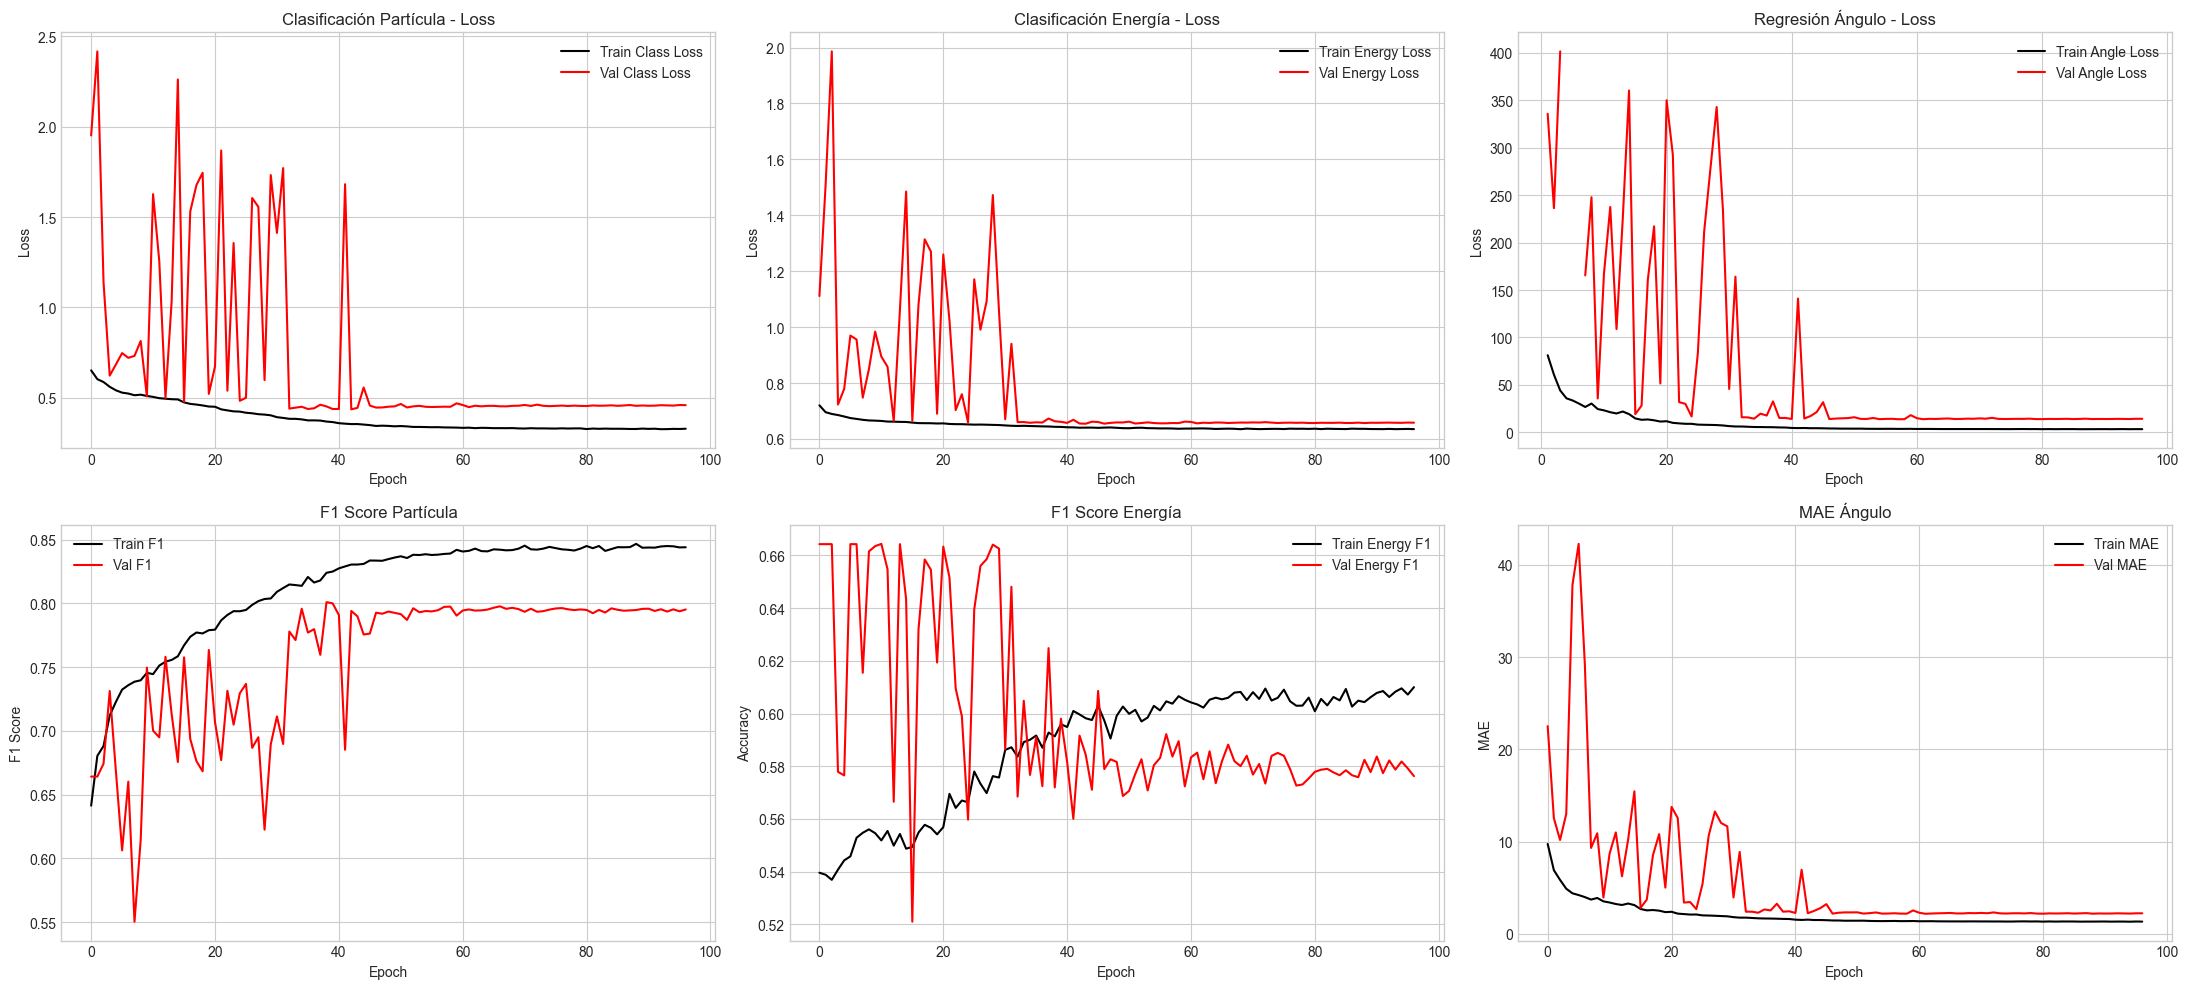

In [104]:
fig, axes = plt.subplots(2, 3, figsize=(22, 10))

# Pérdida de clasificación (partícula)
axes[0, 0].plot(history_multi.history['particle_output_loss'], label='Train Class Loss', color='black')
axes[0, 0].plot(history_multi.history['val_particle_output_loss'], label='Val Class Loss', color='red')
axes[0, 0].set_title('Clasificación Partícula - Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Pérdida de clasificación (energía)
axes[0, 1].plot(history_multi.history['energy_output_loss'], label='Train Energy Loss', color='black')
axes[0, 1].plot(history_multi.history['val_energy_output_loss'], label='Val Energy Loss', color='red')
axes[0, 1].set_title('Clasificación Energía - Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Pérdida de regresión de ángulo
axes[0, 2].plot(history_multi.history['angle_output_loss'], label='Train Angle Loss', color='black')
axes[0, 2].plot(history_multi.history['val_angle_output_loss'], label='Val Angle Loss', color='red')
axes[0, 2].set_title('Regresión Ángulo - Loss')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].legend()
axes[0, 2].grid(True)

# F1-score (clasificación partícula)
axes[1, 0].plot(history_multi.history['particle_output_f1_metric'], label='Train F1', color='black')
axes[1, 0].plot(history_multi.history['val_particle_output_f1_metric'], label='Val F1', color='red')
axes[1, 0].set_title('F1 Score Partícula')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Accuracy (clasificación energía)
axes[1, 1].plot(history_multi.history['energy_output_f1_metric'], label='Train Energy F1', color='black')
axes[1, 1].plot(history_multi.history['val_energy_output_f1_metric'], label='Val Energy F1', color='red')
axes[1, 1].set_title('F1 Score Energía')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

# MAE (regresión de ángulo)
axes[1, 2].plot(history_multi.history['angle_output_mae'], label='Train MAE', color='black')
axes[1, 2].plot(history_multi.history['val_angle_output_mae'], label='Val MAE', color='red')
axes[1, 2].set_title('MAE Ángulo')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('MAE')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "multitask_all_curves.png"))
plt.show()


In [105]:
# Evaluación en test para el modelo multitarea (incluyendo energía)
y_energy_test_bin = (y_energy_test == '8E2').astype(int)
test_res_multi = model_multi.evaluate(
    x={'seq_input': X_seq_test_norm},
    y={
        'particle_output': y_lbl_test,
        'energy_output': y_energy_test_bin,
        'angle_output': y_ang_test
    },
    verbose=1
)
print("Resultados finales en Test (Multitarea - Clasificación, Energía y Ángulo):", test_res_multi)


307/307 [==============================] - 4s 13ms/step - loss: 15.0845 - particle_output_loss: 0.4663 - energy_output_loss: 0.6570 - angle_output_loss: 13.9609 - particle_output_f1_metric: 0.7883 - energy_output_f1_metric: 0.5699 - angle_output_mae: 2.2346
Resultados finales en Test (Multitarea - Clasificación, Energía y Ángulo): [15.084461212158203, 0.466251939535141, 0.6569913625717163, 13.9609375, 0.7882835268974304, 0.569872260093689, 2.2345871925354004]


In [106]:
# Generar predicciones para el set de test usando el modelo multitarea
y_pred_cl, y_pred_energy, y_pred_angle = model_multi.predict({'seq_input': X_seq_test_norm}, verbose=1)
y_pred_cl = (y_pred_cl > 0.5).astype(int).flatten()         # Clasificación binaria partícula
y_pred_energy = (y_pred_energy > 0.5).astype(int).flatten() # Clasificación binaria energía
y_pred_angle = y_pred_angle.flatten()

# Formar DataFrame de predicciones
df_pred = pd.DataFrame({
    'y_true_label': y_lbl_test,
    'y_pred_label': y_pred_cl,
    'y_true_energy': y_energy_test,
    'y_pred_energy': y_pred_energy,
    'y_true_angle': y_ang_test,
    'y_pred_angle': y_pred_angle
})


307/307 [==============================] - 4s 12ms/step


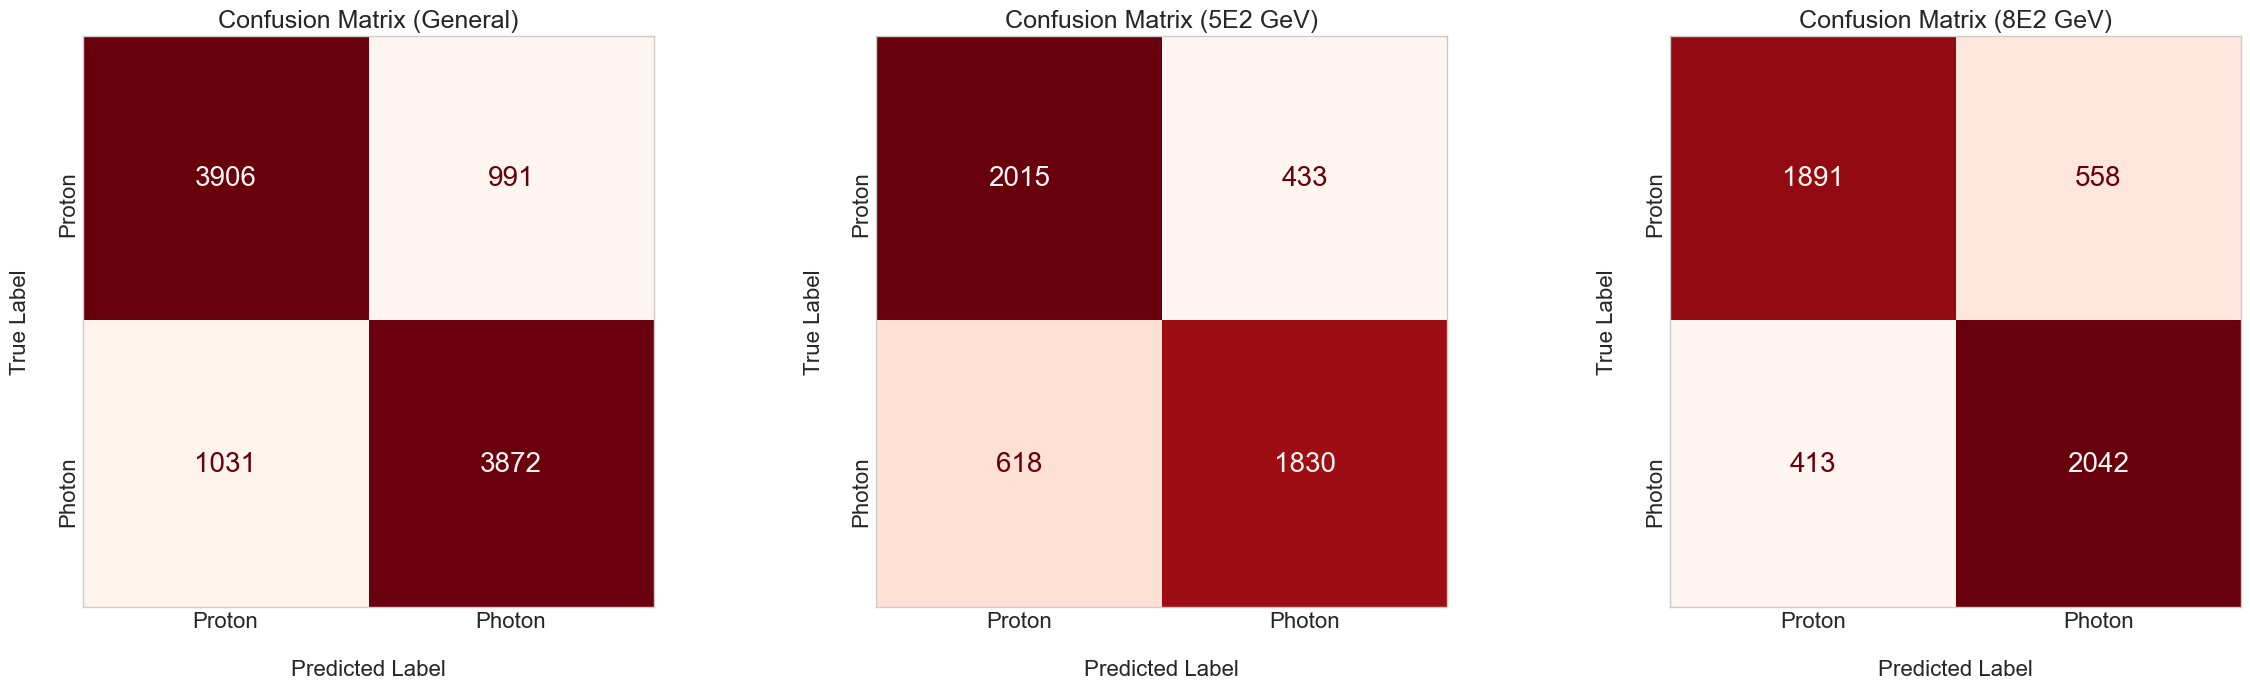

In [107]:
unique_energies = np.unique(y_energy_test)
n_energies = len(unique_energies)
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

cm = confusion_matrix(y_lbl_test, y_pred_cl, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Proton', 'Photon'])
disp.plot(ax=axes[0], cmap='Reds', colorbar=False, text_kw={'fontsize': 20})
axes[0].set_xlabel("Predicted Label", fontsize=16, labelpad=20)
axes[0].set_ylabel("True Label", fontsize=16, labelpad=20)
axes[0].set_xticklabels(['Proton', 'Photon'], fontsize=16)
axes[0].set_yticklabels(['Proton', 'Photon'], fontsize=16, rotation=90)
axes[0].grid(False)
axes[0].set_title("Confusion Matrix (General)", fontsize=18)

for i, energy_val in enumerate(unique_energies):
    mask = y_energy_test == energy_val
    cm = confusion_matrix(y_lbl_test[mask], y_pred_cl[mask], labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Proton', 'Photon'])
    disp.plot(ax=axes[i+1], cmap='Reds', colorbar=False, text_kw={'fontsize': 20})
    axes[i+1].set_xlabel("Predicted Label", fontsize=16, labelpad=20)
    axes[i+1].set_ylabel("True Label", fontsize=16, labelpad=20)
    axes[i+1].set_xticklabels(['Proton', 'Photon'], fontsize=16)
    axes[i+1].set_yticklabels(['Proton', 'Photon'], fontsize=16, rotation=90)
    axes[i+1].grid(False)
    axes[i+1].set_title(f"Confusion Matrix ({energy_val} GeV)", fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "confusion_matrix_by_energy.png"))
plt.show()

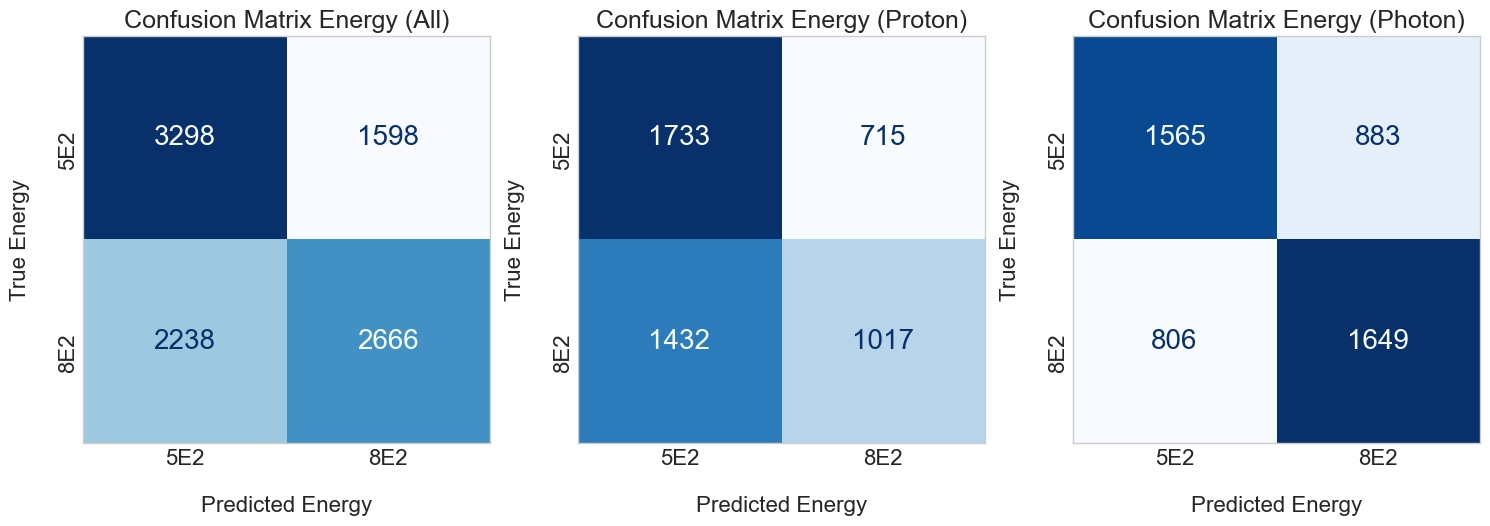

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

unique_energies = np.unique(y_energy_test)
energy_to_idx = {e: i for i, e in enumerate(unique_energies)}
n_energies = len(unique_energies)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

y_true_energy_idx = np.vectorize(energy_to_idx.get)(y_energy_test)
y_pred_energy_idx = y_pred_energy
cm = confusion_matrix(y_true_energy_idx, y_pred_energy_idx, labels=range(n_energies))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_energies)
disp.plot(ax=axes[0], cmap='Blues', colorbar=False, text_kw={'fontsize': 20})
axes[0].set_xlabel("Predicted Energy", fontsize=16, labelpad=20)
axes[0].set_ylabel("True Energy", fontsize=16, labelpad=20)
axes[0].set_xticklabels(unique_energies, fontsize=16)
axes[0].set_yticklabels(unique_energies, fontsize=16, rotation=90)
axes[0].grid(False)
axes[0].set_title("Confusion Matrix Energy (All)", fontsize=18)

for i, (label_value, label_name) in enumerate([(0, 'Proton'), (1, 'Photon')]):
    mask = y_lbl_test == label_value
    y_true_energy_idx = np.vectorize(energy_to_idx.get)(y_energy_test[mask])
    y_pred_energy_idx = y_pred_energy[mask]
    cm = confusion_matrix(y_true_energy_idx, y_pred_energy_idx, labels=range(n_energies))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_energies)
    disp.plot(ax=axes[i+1], cmap='Blues', colorbar=False, text_kw={'fontsize': 20})
    axes[i+1].set_xlabel("Predicted Energy", fontsize=16, labelpad=20)
    axes[i+1].set_ylabel("True Energy", fontsize=16, labelpad=20)
    axes[i+1].set_xticklabels(unique_energies, fontsize=16)
    axes[i+1].set_yticklabels(unique_energies, fontsize=16, rotation=90)
    axes[i+1].grid(False)
    axes[i+1].set_title(f"Confusion Matrix Energy ({label_name})", fontsize=18)


plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "confusion_matrix_energy_by_particle.png"))
plt.show()

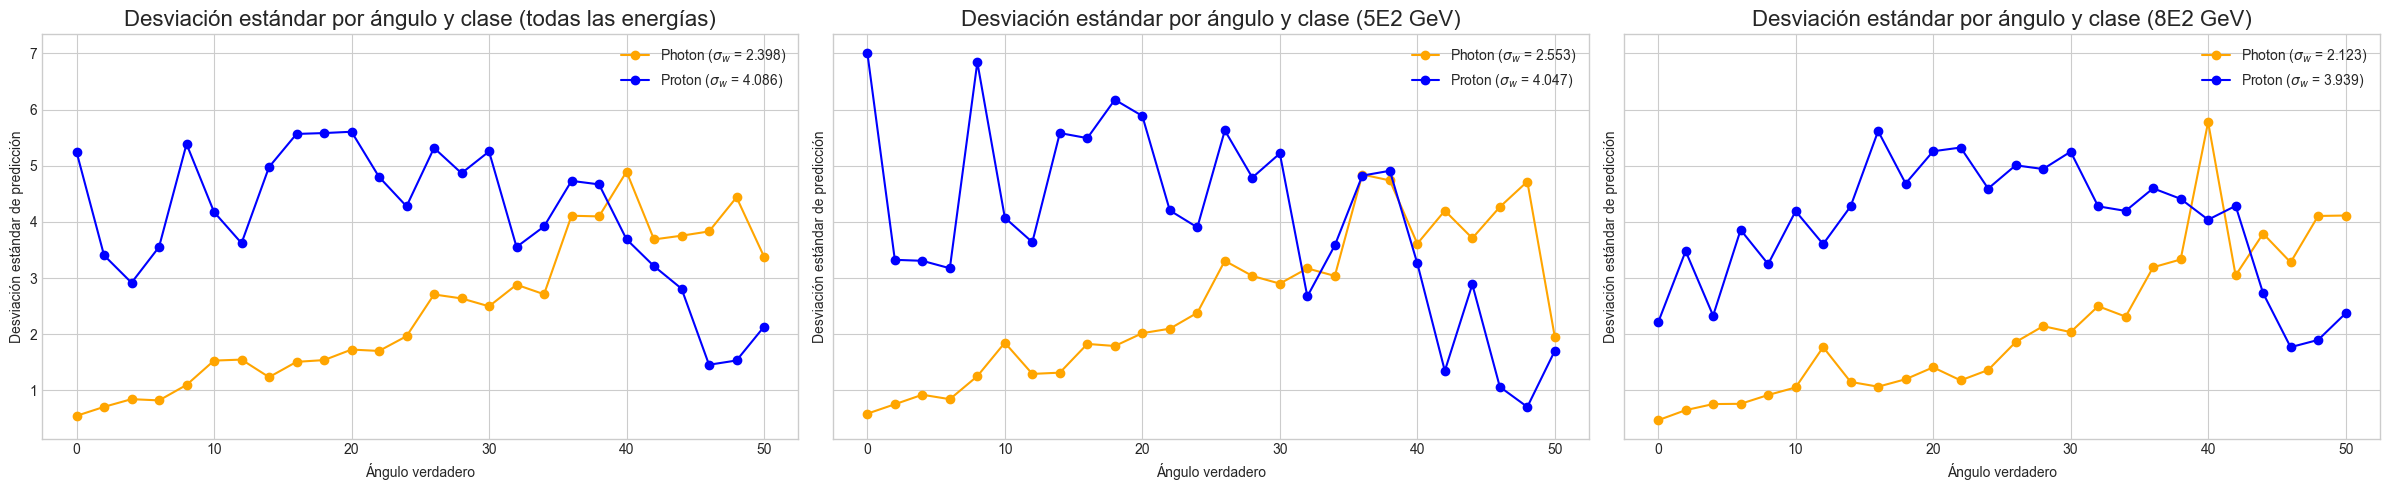

In [109]:
# Calcular la desviación estándar de las predicciones por ángulo y clase para todas las energías presentes
unique_angles = np.unique(y_ang_test)
unique_energies = np.unique(y_energy_test)

fig, axes = plt.subplots(1, len(unique_energies) + 1, figsize=(8 * (len(unique_energies) + 1), 5), sharey=True)

if len(unique_energies) == 1:
    axes = [axes]

# Plot general
stds_photon = []
stds_proton = []
for ang in unique_angles:
    preds_photon = y_pred_angle[(y_ang_test == ang) & (y_lbl_test == 1)]
    preds_proton = y_pred_angle[(y_ang_test == ang) & (y_lbl_test == 0)]
    stds_photon.append(np.std(preds_photon))
    stds_proton.append(np.std(preds_proton))
mean_std_photon = np.nanmean(stds_photon)
mean_std_proton = np.nanmean(stds_proton)

ax = axes[0]
ax.plot(unique_angles, stds_photon, marker='o', label=f'Photon ($\sigma_w$ = {mean_std_photon:.3f})', color='orange')
ax.plot(unique_angles, stds_proton, marker='o', label=f'Proton ($\sigma_w$ = {mean_std_proton:.3f})', color='blue')
ax.set_xlabel("Ángulo verdadero")
ax.set_ylabel("Desviación estándar de predicción")
ax.set_title(f"Desviación estándar por ángulo y clase (todas las energías)", fontsize=16)
ax.legend()
ax.grid(True)

# Plot por energía
for i, energy_val in enumerate(unique_energies):
    mask_energy = y_energy_test == energy_val
    stds_photon = []
    stds_proton = []
    for ang in unique_angles:
        preds_photon = y_pred_angle[(y_ang_test == ang) & (y_lbl_test == 1) & mask_energy]
        preds_proton = y_pred_angle[(y_ang_test == ang) & (y_lbl_test == 0) & mask_energy]
        stds_photon.append(np.std(preds_photon))
        stds_proton.append(np.std(preds_proton))
    mean_std_photon = np.nanmean(stds_photon)
    mean_std_proton = np.nanmean(stds_proton)

    ax = axes[i + 1]
    ax.plot(unique_angles, stds_photon, marker='o', label=f'Photon ($\sigma_w$ = {mean_std_photon:.3f})', color='orange')
    ax.plot(unique_angles, stds_proton, marker='o', label=f'Proton ($\sigma_w$ = {mean_std_proton:.3f})', color='blue')
    ax.set_xlabel("Ángulo verdadero")
    ax.set_ylabel("Desviación estándar de predicción")
    ax.set_title(f"Desviación estándar por ángulo y clase ({energy_val} GeV)", fontsize=16)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


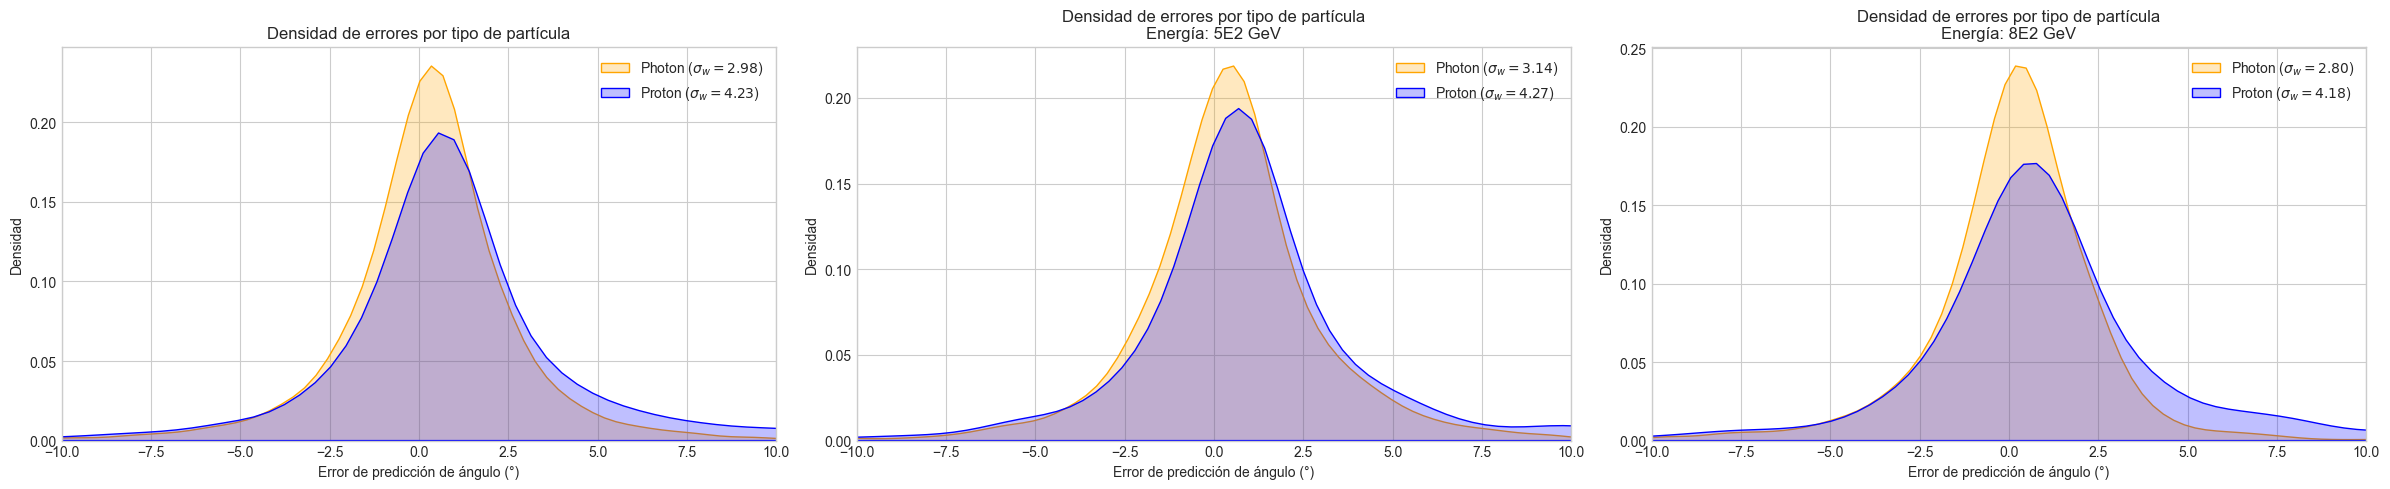

In [110]:
# KDE de errores de predicción de ángulo en general y por tipo de partícula y energía (adaptado a cualquier cantidad de energías)
unique_energies = np.unique(y_energy_test)
n_energies = len(unique_energies)
plt.figure(figsize=(8 * (n_energies + 1), 5))

# Plot de errores en general
plt.subplot(1, n_energies + 1, 1)
errors_photon = (y_pred_angle - y_ang_test)[y_lbl_test == 1]
errors_proton = (y_pred_angle - y_ang_test)[y_lbl_test == 0]
mean_std_photon = np.std(errors_photon)
mean_std_proton = np.std(errors_proton)
sns.kdeplot(errors_photon, label=f'Photon ($\sigma_w = {mean_std_photon:.2f}$)', fill=True, color='orange')
sns.kdeplot(errors_proton, label=f'Proton ($\sigma_w = {mean_std_proton:.2f}$)', fill=True, color='blue')
plt.xlabel("Error de predicción de ángulo (°)")
plt.ylabel("Densidad")
plt.title("Densidad de errores por tipo de partícula")
plt.xlim(-10, 10)
plt.legend()
plt.grid(True)

# Plots de errores por tipo de partícula y energía
for i, energy_val in enumerate(unique_energies):
    plt.subplot(1, n_energies + 1, i + 2)
    mask = y_energy_test == energy_val
    errors_photon = (y_pred_angle - y_ang_test)[(y_lbl_test == 1) & mask]
    errors_proton = (y_pred_angle - y_ang_test)[(y_lbl_test == 0) & mask]
    mean_std_photon = np.std(errors_photon)
    mean_std_proton = np.std(errors_proton)
    sns.kdeplot(errors_photon, label=f'Photon ($\sigma_w = {mean_std_photon:.2f}$)', fill=True, color='orange')
    sns.kdeplot(errors_proton, label=f'Proton ($\sigma_w = {mean_std_proton:.2f}$)', fill=True, color='blue')
    plt.xlabel("Error de predicción de ángulo (°)")
    plt.ylabel("Densidad")
    plt.title(f"Densidad de errores por tipo de partícula\nEnergía: {energy_val} GeV")
    plt.xlim(-10, 10)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "kde_error_prediccion_angulo_por_energia.png"))
plt.show()


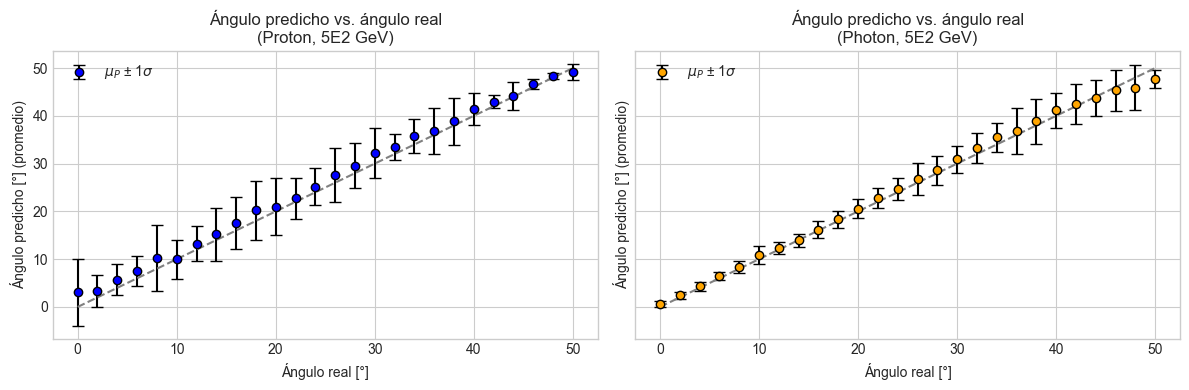

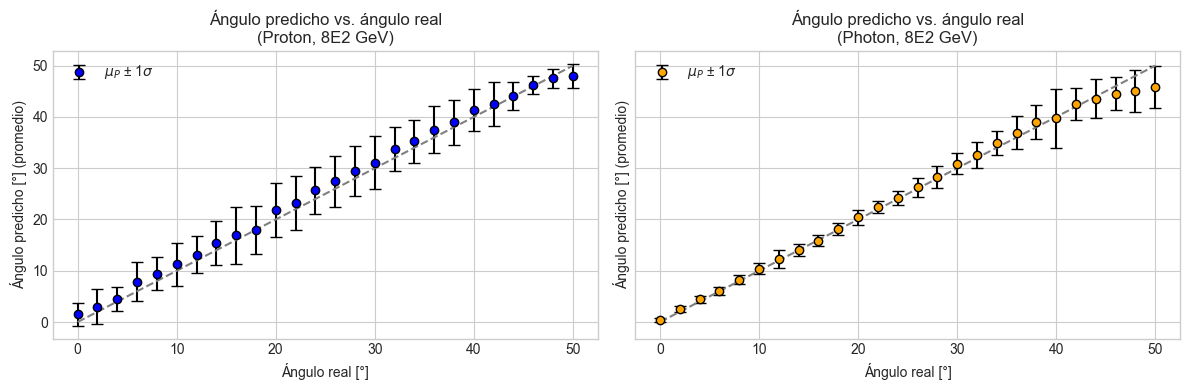

In [111]:
# Obtener las energías únicas automáticamente desde y_energy_test
unique_energies = np.unique(y_energy_test)

# Visualizar promedio y desviación estándar de predicciones por ángulo, clase y energía
for energy_val in unique_energies:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    mask_energy = y_energy_test == energy_val
    for ax, (label_value, label_name) in zip(axes, {0: 'Proton', 1: 'Photon'}.items()):
        means = []
        stds = []
        for ang in unique_angles:
            mask = (y_ang_test == ang) & (y_lbl_test == label_value) & mask_energy
            preds = y_pred_angle[mask]
            means.append(np.mean(preds) if preds.size > 0 else np.nan)
            stds.append(np.std(preds) if preds.size > 0 else np.nan)
        means = np.array(means)
        stds = np.array(stds)

        color = 'blue' if label_value == 0 else 'orange'
        ax.errorbar(unique_angles, means, yerr=stds, fmt='o', capsize=4,
                    ecolor='black', color=color, markerfacecolor=color,
                    markeredgecolor='black', label='$\mu_P$ ± 1$\sigma$')
        ax.plot(unique_angles, unique_angles, '--', color='gray')
        ax.set_xlabel("Ángulo real [°]")
        ax.set_ylabel("Ángulo predicho [°] (promedio)")
        ax.set_title(f"Ángulo predicho vs. ángulo real\n({label_name}, {energy_val} GeV)")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(predicts_dir, f"pred_vs_real_angle_by_class_{energy_val}.png"))
    plt.show()

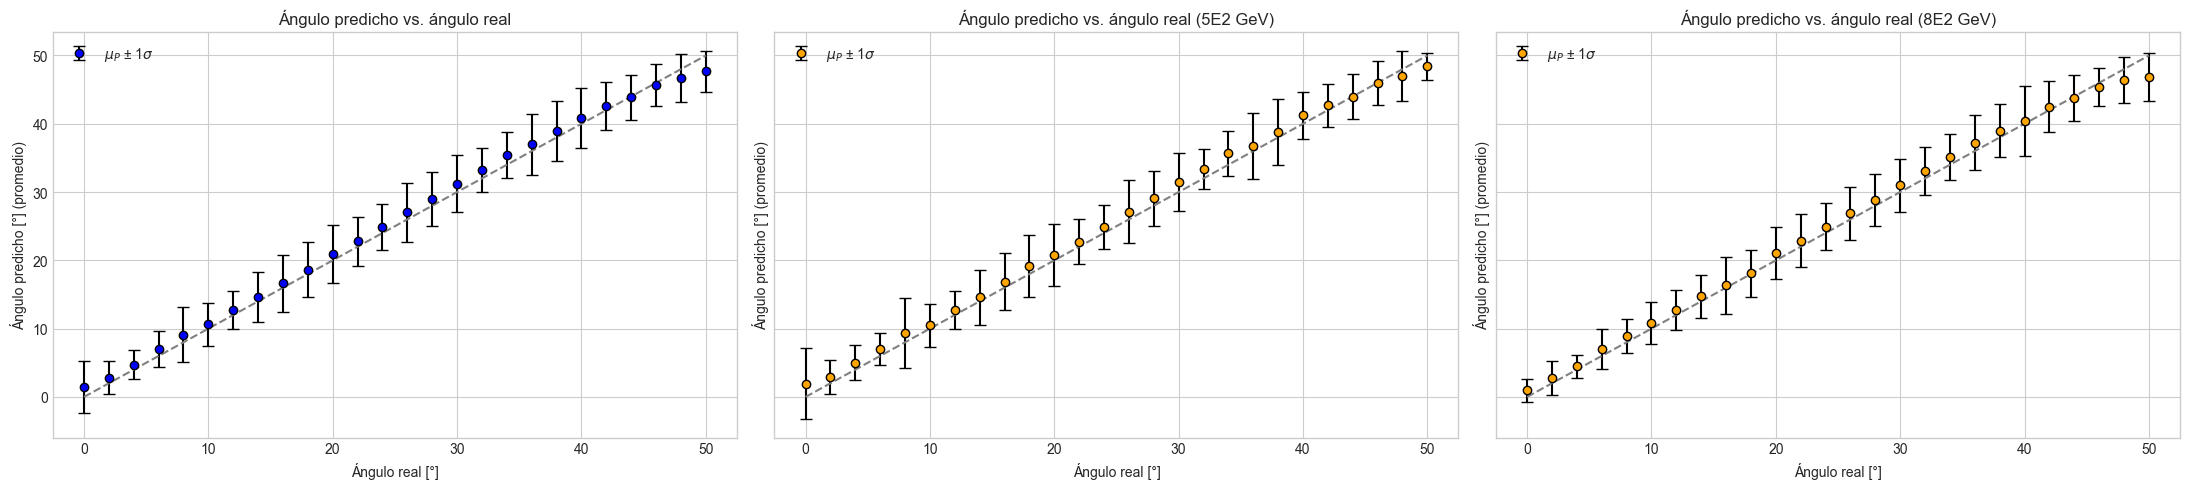

In [112]:
# Visualizar promedio y desviación estándar de predicciones por ángulo, clase y energía
fig, axes = plt.subplots(1, 3, figsize=(22, 5), sharey=True)
# Primero, predicciones en general
means = []
stds = []
for ang in unique_angles:
    mask = y_ang_test == ang
    preds = y_pred_angle[mask]
    means.append(np.mean(preds) if preds.size > 0 else np.nan)
    stds.append(np.std(preds) if preds.size > 0 else np.nan)
means = np.array(means)
stds = np.array(stds)
axes[0].errorbar(unique_angles, means, yerr=stds, fmt='o', capsize=4,
                 ecolor='black', color='blue', markerfacecolor='blue',
                 markeredgecolor='black', label='$\mu_P$ ± 1$\sigma$')
axes[0].plot(unique_angles, unique_angles, '--', color='gray')
axes[0].set_xlabel("Ángulo real [°]")
axes[0].set_ylabel("Ángulo predicho [°] (promedio)")
axes[0].set_title("Ángulo predicho vs. ángulo real")
axes[0].legend()
axes[0].grid(True)
# Luego, predicciones separadas por energía
for i, energy_val in enumerate(unique_energies):
    mask_energy = y_energy_test == energy_val
    means = []
    stds = []
    for ang in unique_angles:
        mask = (y_ang_test == ang) & mask_energy
        preds = y_pred_angle[mask]
        means.append(np.mean(preds) if preds.size > 0 else np.nan)
        stds.append(np.std(preds) if preds.size > 0 else np.nan)
    means = np.array(means)
    stds = np.array(stds)
    axes[1 + i].errorbar(unique_angles, means, yerr=stds, fmt='o', capsize=4,
                         ecolor='black', color='orange', markerfacecolor='orange',
                         markeredgecolor='black', label='$\mu_P$ ± 1$\sigma$')
    axes[1 + i].plot(unique_angles, unique_angles, '--', color='gray')
    axes[1 + i].set_xlabel("Ángulo real [°]")
    axes[1 + i].set_ylabel("Ángulo predicho [°] (promedio)")
    axes[1 + i].set_title(f"Ángulo predicho vs. ángulo real ({energy_val} GeV)")
    axes[1 + i].legend()
    axes[1 + i].grid(True)
plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "pred_vs_real_angle_by_class_and_energy.png"))
plt.show()


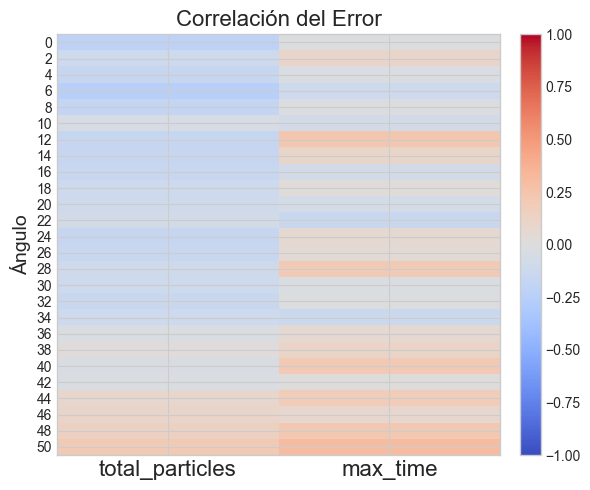

In [113]:
# Calcula el error de predicción de ángulo
angle_errors = y_pred_angle - y_ang_test

# DataFrame con información relevante
df_corr = pd.DataFrame({
    'error': angle_errors,
    'total_particles': X_ext_bal[test_idx][:, 0],
    'max_time': X_ext_bal[test_idx][:, 1],
    'angle': y_ang_test
})

# Calcula la correlación para cada ángulo y muestra como mapa de calor
corrs = []
for ang in unique_angles:
    df_a = df_corr[df_corr['angle'] == ang]
    if len(df_a) > 2:
        corr = df_a[['error', 'total_particles', 'max_time']].corr()
        corrs.append(corr.values)
    else:
        corrs.append(np.full((3,3), np.nan))

corrs = np.array(corrs)  # shape: (n_angles, 3, 3)

# Solo el primer gráfico: correlación del error con las otras variables
i = 0  # 'error'
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
labels = ['error', 'total_particles', 'max_time']

data = np.delete(corrs[:, i, :], i, axis=1)
im = ax.imshow(data, aspect='auto', vmin=-1, vmax=1, cmap='coolwarm',
               extent=[-0.5, 1.5, unique_angles[-1]+1, unique_angles[0]-1])
xtick_labels = [l for j, l in enumerate(labels) if j != i]
ax.set_xticks(range(2))
ax.set_xticklabels(xtick_labels, fontsize=16)  # Aumenta el fontsize aquí
ax.set_yticks(unique_angles)
ax.set_yticklabels([f"{a:.0f}" for a in unique_angles])
ax.set_title(f"Correlación del Error", fontsize=16)
ax.set_ylabel("Ángulo", fontsize=14)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
